<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/rod/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet de Python** : Détection de fraude bancaire à l'aide d'algorithmes de Machine Learning


## Introduction et présentation du projet

**Introduction**

**Source des données**

**Intérêt et objectifs du projet**

## Initialisation de l'environnement de travail

Etant donné la complexité du projet et le format particulier mais novateur des données utilisées, des méthodes de ML appliquées aux données volumineuses ont été utilisées. De ce fait, des packages supplémentaires ont dû être installé. Il s'agit en particulier de :


*   **impyute** : pour l'imputation de données manquantes par la méthode ***MICE***
*   **dask** : pour l'utilisation de calculs distribués
*   **dask-ml** : pour exécuter les algorithmes de machines learning sur données distribuées
*   Élément de liste



In [24]:
!pip install impyute
!pip install dask
!pip install dask-ml
!pip install distributed

Viens ensuite la phase de chargement de tous les packages nécessaires.

In [106]:
# Chargement des packages
import os
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
import time
import joblib
import warnings
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from dask.distributed import Client
from dask_ml.linear_model import LogisticRegression as dd_LogisticRegression
from google.colab import drive
from sklearn.impute import KNNImputer
from dask.distributed import Client

On charge l'ensemble des bases de données à partir de Google Drive. C'est une solution satisfaisante étant donné qu'elle permet non seulement un travail collaboratif beaucoup plus précis mais aussi une liaison aux données beaucoup plus aisée dû à l'utilisation de Google Colab.

In [26]:
# Connexion à google drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#On fait un petit test pour comparer les temps d'importation des bases par pandas et dask
%time test_time = pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 

CPU times: user 678 ms, sys: 77.3 ms, total: 755 ms
Wall time: 781 ms


In [28]:
%time test_time = dd.read_csv('/content/drive/My Drive/projet python/train_identity.csv') 
del test_time

CPU times: user 31.9 ms, sys: 5.01 ms, total: 36.9 ms
Wall time: 44.4 ms


On voit clairement que les temps d'importation sont plus de 10 fois moins longs. De ce fait, **dask** est une altenative efficace pour le travail avec ces bases de données. Toutefois, pour tout ce qui est statistiques descriptives et préprocessing, pandas le gère très bien. De ce fait, nous n'emploierons les versions dask des données que pour la partie modélisation.

In [29]:
# Importation des données
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

In [30]:
## Affichage de plus de lignes pour les output
pd.options.display.max_rows = 500

## On lance un client local pour les calculs distribués
client = Client()

/usr/local/lib/python3.6/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45249 instead
  http_address["port"], self.http_server.port


On lance un client local afin de pouvoir utiliser les syntaxes basiques de traitement de données. Il suffira de faire appel à ligne de commande : *with parallel_backend('dask')*
Cette méthode est satisfisante car elle assure non seulement la facile maintenance du code mais aussi la compréhension par des utilisateurs externes de Python.

## Exploration des données

**Visualisation des données**

In [31]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [32]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [34]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [35]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

### **Statistiques descriptives sur les données**

In [36]:
#Dimension de la base de donnée 
train.shape

(144233, 434)

* **IsFraud**

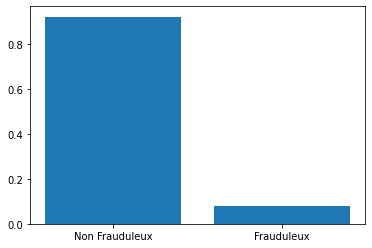

In [37]:
#Repartition des transactions frauduleuses dans la base principale
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

bars = ax.bar(x=np.arange(tab.size),height=tab['TransactionID'],tick_label=['Non Frauduleux', 'Frauduleux'])

* **TransactionAmt**

count    144233.000000
mean         83.554533
std          99.850258
min           0.251000
25%          25.453000
50%          50.000000
75%         100.000000
max        1800.000000
Name: TransactionAmt, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

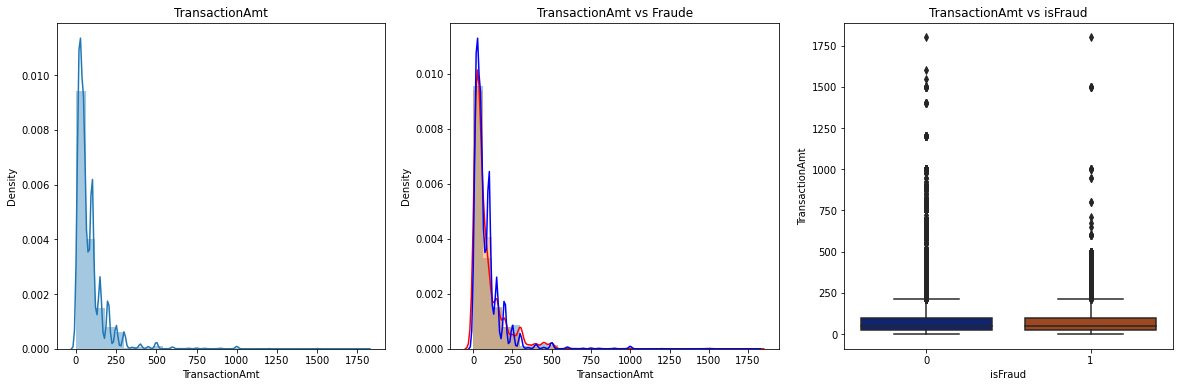

In [38]:
#Apercu générale sur la variable
print(train['TransactionAmt'].describe())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,3,1)
sns.distplot(train.TransactionAmt,bins=30,label='TransactionAmt')
plt.title('TransactionAmt')

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,3,2)
sns.distplot(train[train['isFraud']==1].TransactionAmt,bins=30,kde_kws={"color": "r"},label='TransactionAmt_Fraude')
sns.distplot(train[train['isFraud']==0].TransactionAmt,bins=30,kde_kws={"color": "b"},label='TransactionAmt_Nofraude')
plt.title('TransactionAmt vs Fraude')

plt.subplot(1,3,3)
sns.boxplot(x='isFraud', y='TransactionAmt',data=train,palette='dark')
plt.title('TransactionAmt vs isFraud')
plt.show()


* **Les features Cardi**

count    144233.000000
mean       9879.012528
std        5047.643179
min        1000.000000
25%        5713.000000
50%        9633.000000
75%       15063.000000
max       18396.000000
Name: card1, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

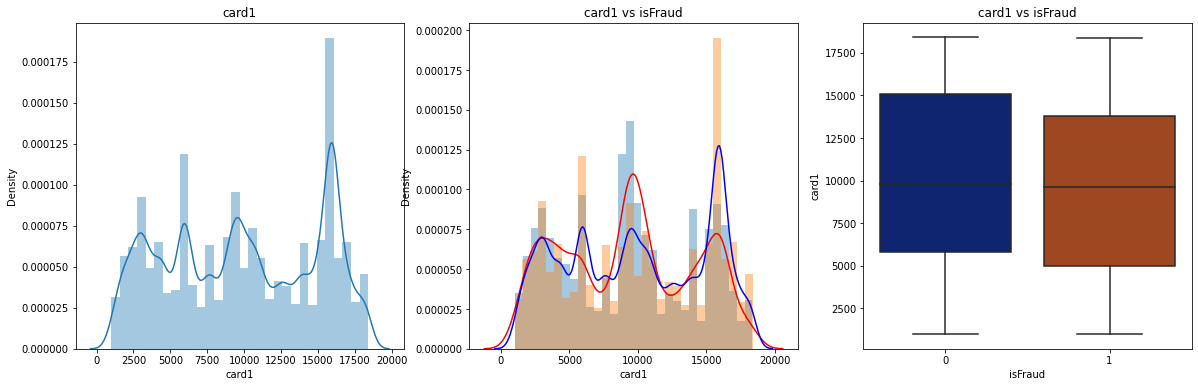

count    143331.000000
mean        391.325526
std         160.327848
min         100.000000
25%         264.000000
50%         408.000000
75%         545.000000
max         600.000000
Name: card2, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

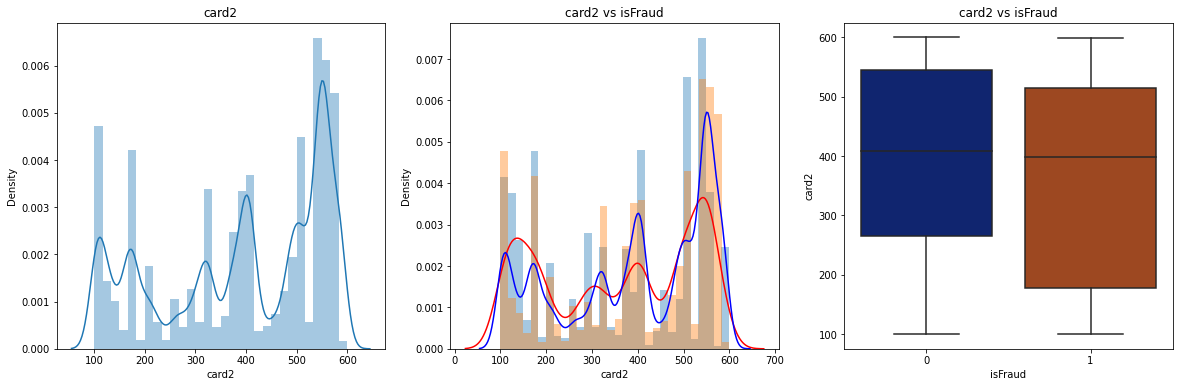

count    144061.000000
mean        161.695504
std          19.410116
min         100.000000
25%         150.000000
50%         150.000000
75%         185.000000
max         231.000000
Name: card3, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

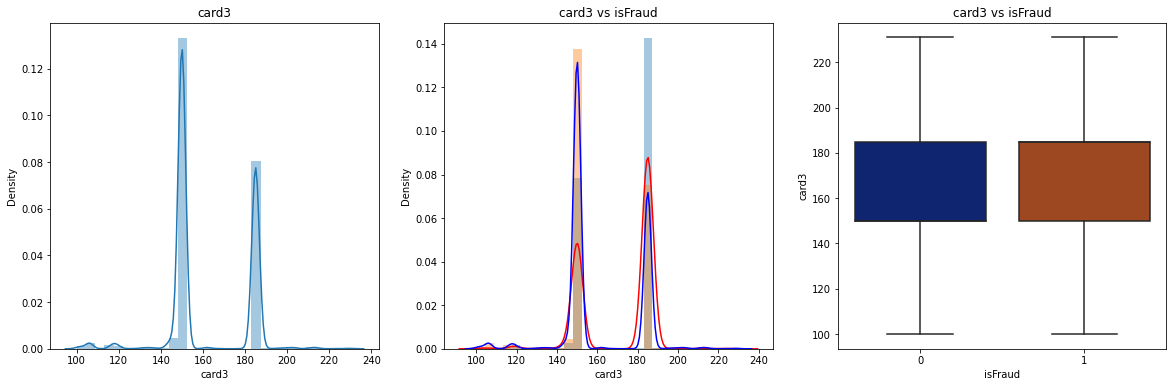

count    143277.000000
mean        191.166293
std          44.774337
min         100.000000
25%         138.000000
50%         224.000000
75%         226.000000
max         237.000000
Name: card5, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

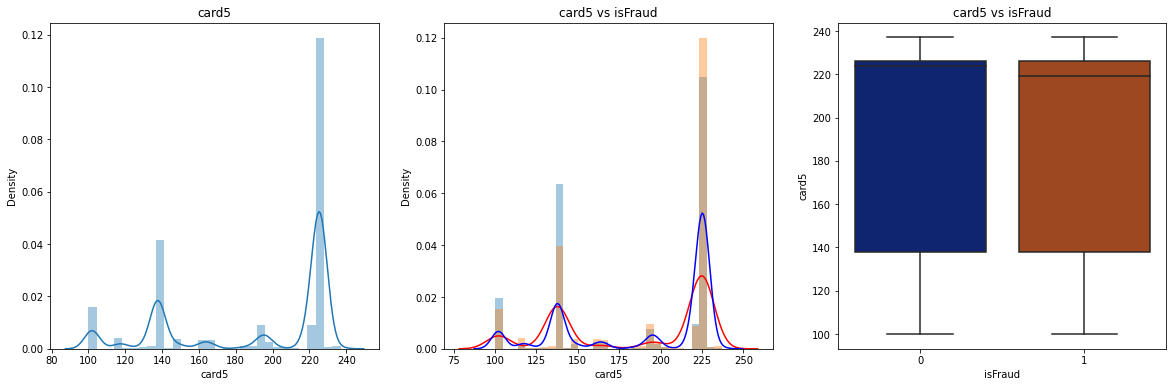

In [39]:
for i in (1,2,3,5):
  varc='card'+str(i)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



* **Les features Ci**

count    144233.000000
mean         27.793681
std         249.745336
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        4685.000000
Name: C1, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

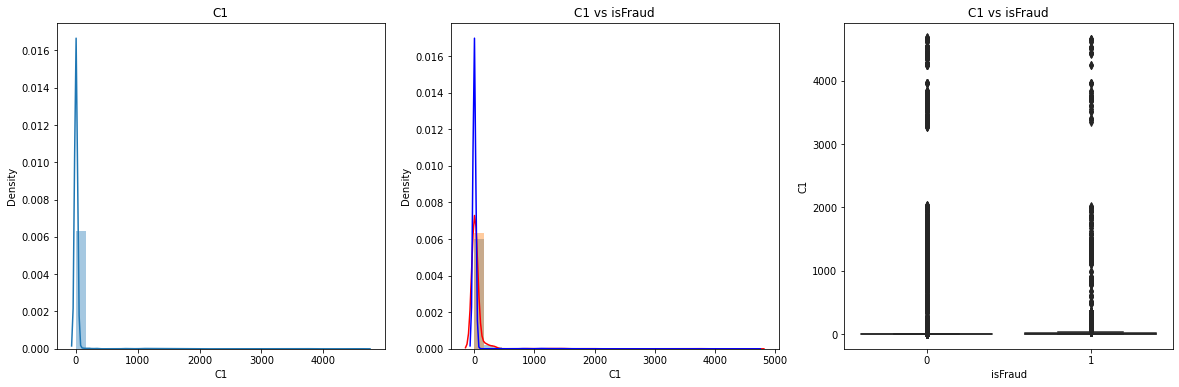

count    144233.000000
mean         34.344533
std         291.306999
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        5691.000000
Name: C2, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

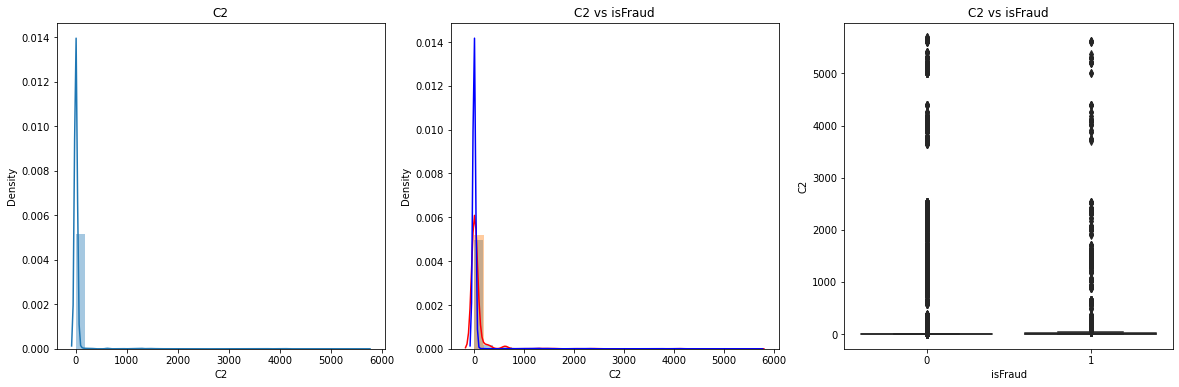

count    144233.000000
mean          0.023032
std           0.303819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: C3, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

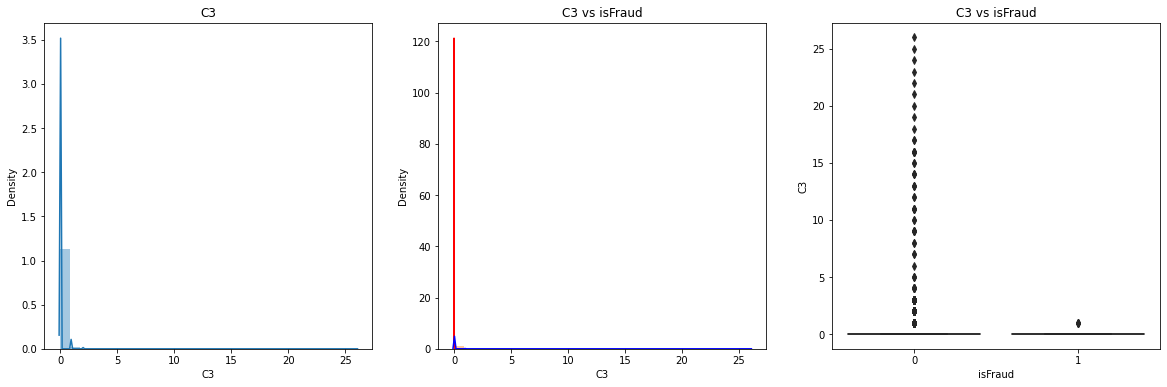

count    144233.000000
mean         15.603558
std         131.944756
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2253.000000
Name: C4, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

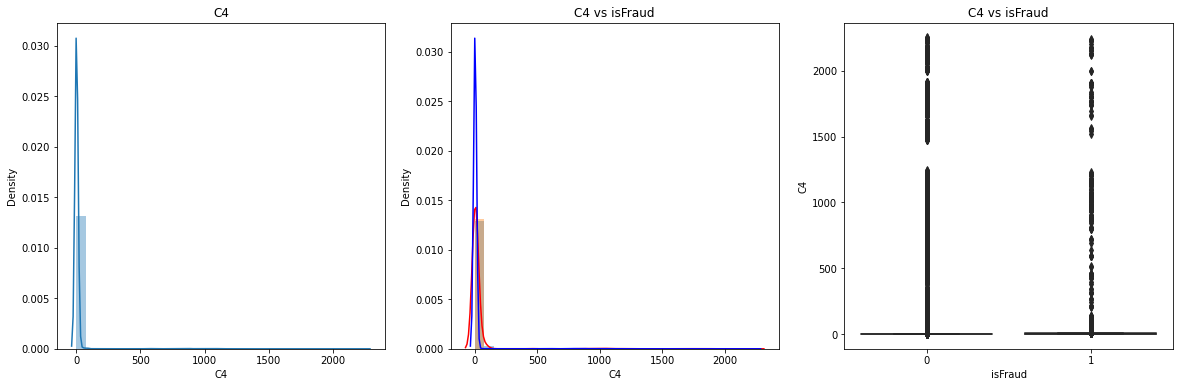

count    144233.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: C5, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate

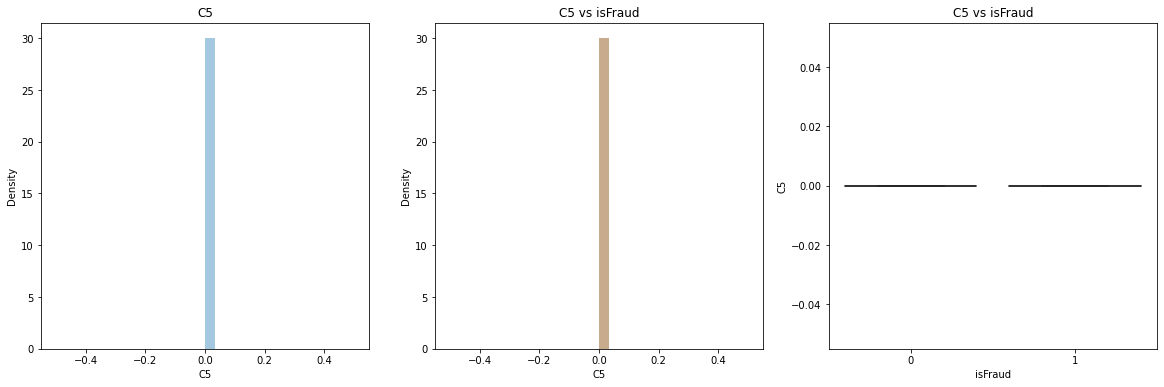

count    144233.000000
mean         15.583036
std         132.514335
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2253.000000
Name: C6, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

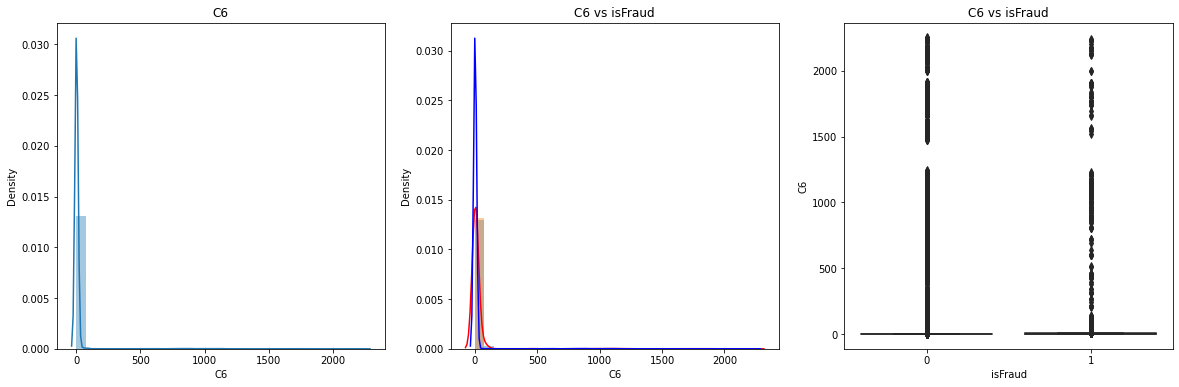

count    144233.000000
mean         10.512830
std         117.037122
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        2255.000000
Name: C7, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

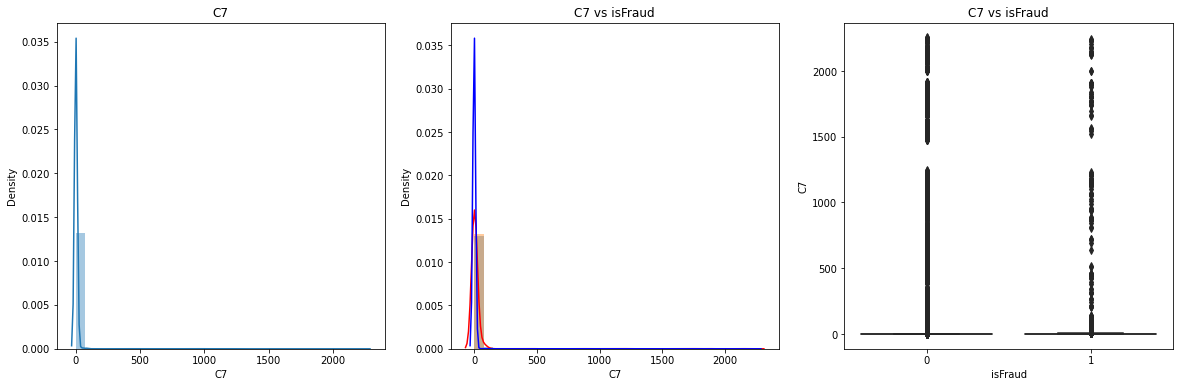

count    144233.000000
mean         19.395173
std         181.039192
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3331.000000
Name: C8, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

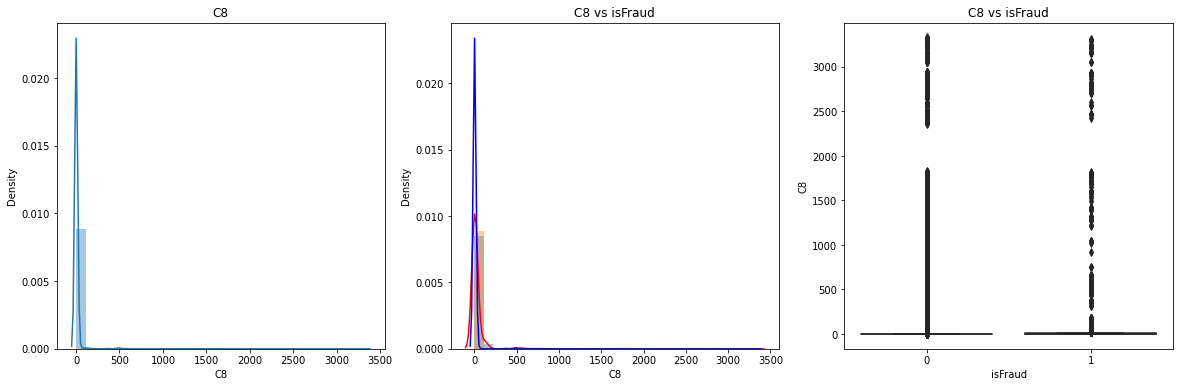

count    144233.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: C9, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate

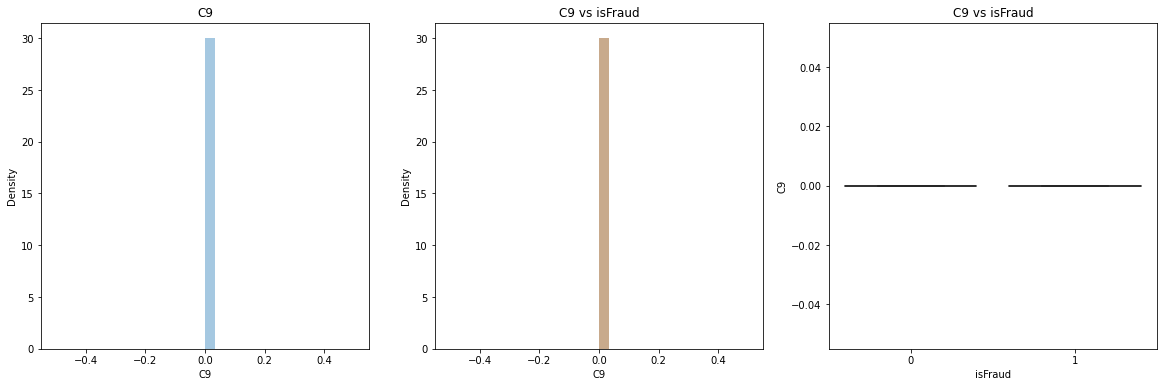

count    144233.000000
mean         19.787483
std         181.760988
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3257.000000
Name: C10, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

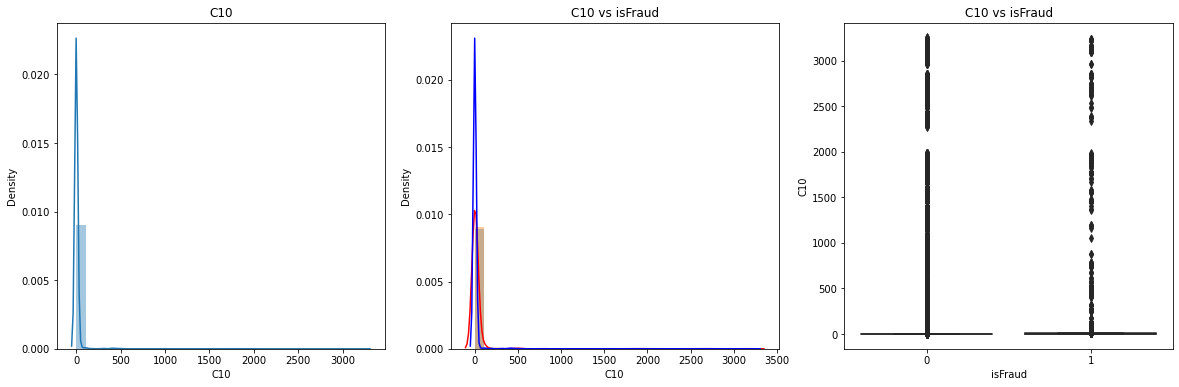

count    144233.000000
mean         20.359425
std         176.778700
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        3188.000000
Name: C11, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

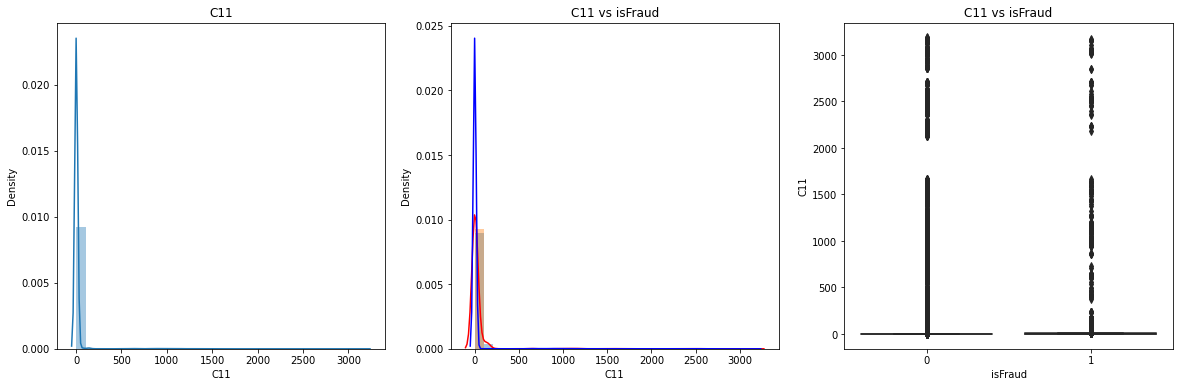

count    144233.000000
mean         14.811687
std         164.194903
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        3188.000000
Name: C12, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

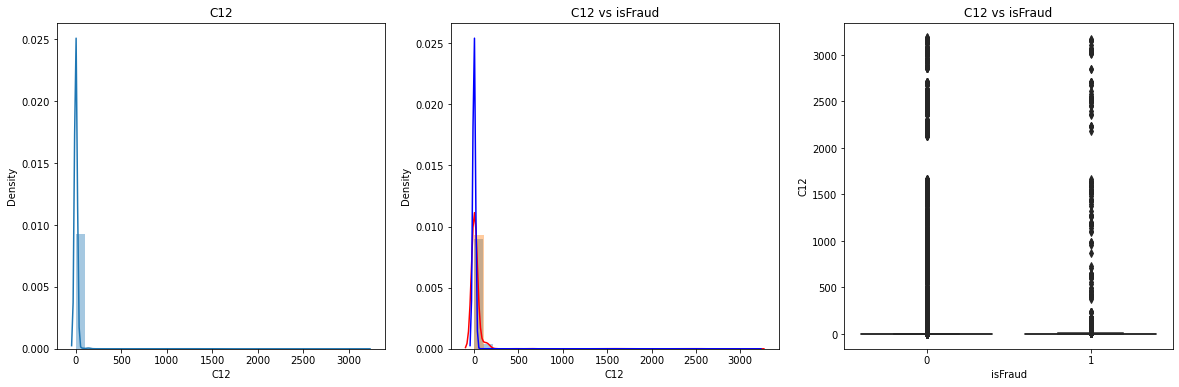

count    144233.000000
mean         20.517850
std         165.660021
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2918.000000
Name: C13, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

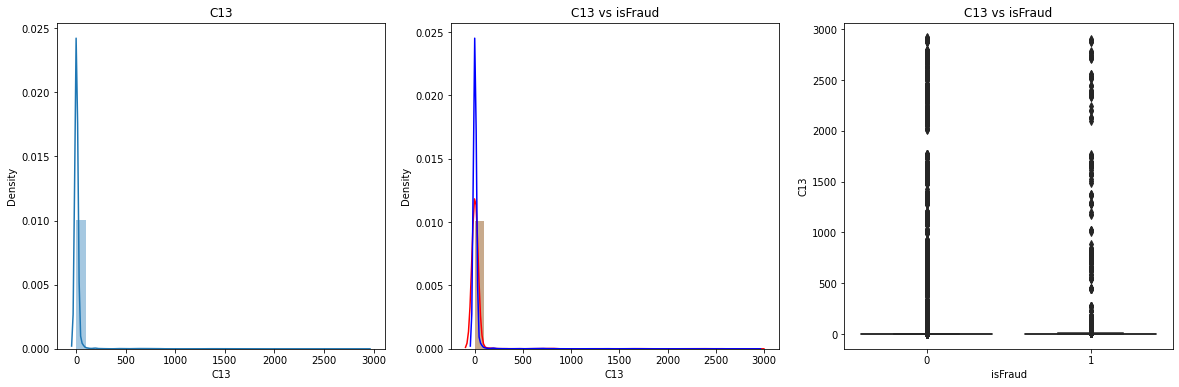

count    144233.000000
mean         10.499685
std          87.186134
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1429.000000
Name: C14, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

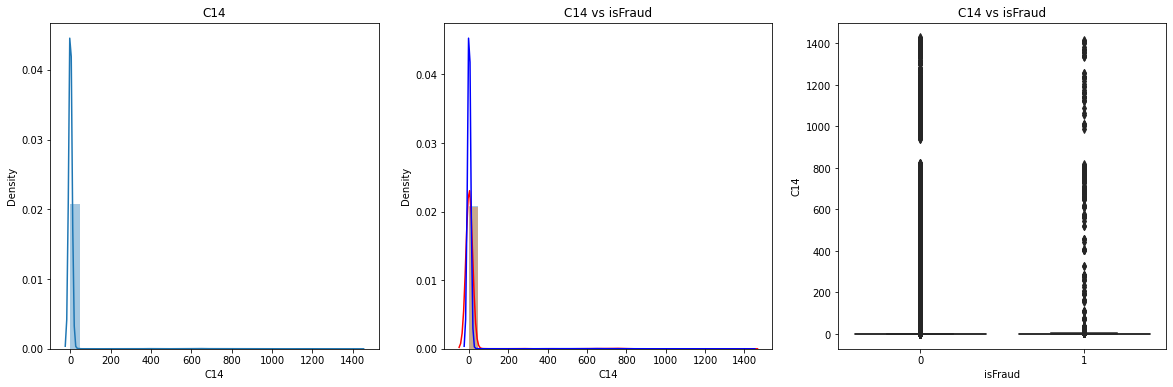

In [40]:
for i in range(14):
  varc='C'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Feature D1**

count    144015.000000
mean         29.313724
std          95.198009
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         640.000000
Name: D1, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

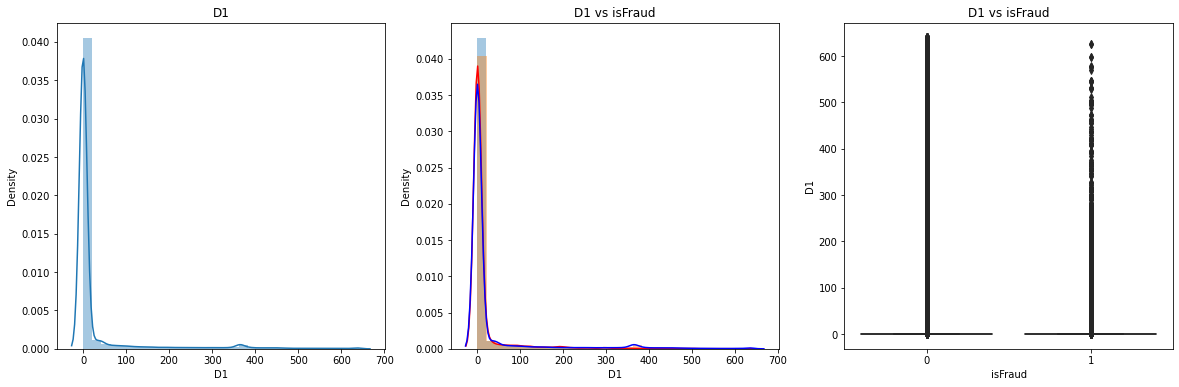

In [41]:
for i in range(1):
  varc='D'+str(i+1)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Features Vi**

count    144169.000000
mean          3.562839
std          42.394744
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         880.000000
Name: V95, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

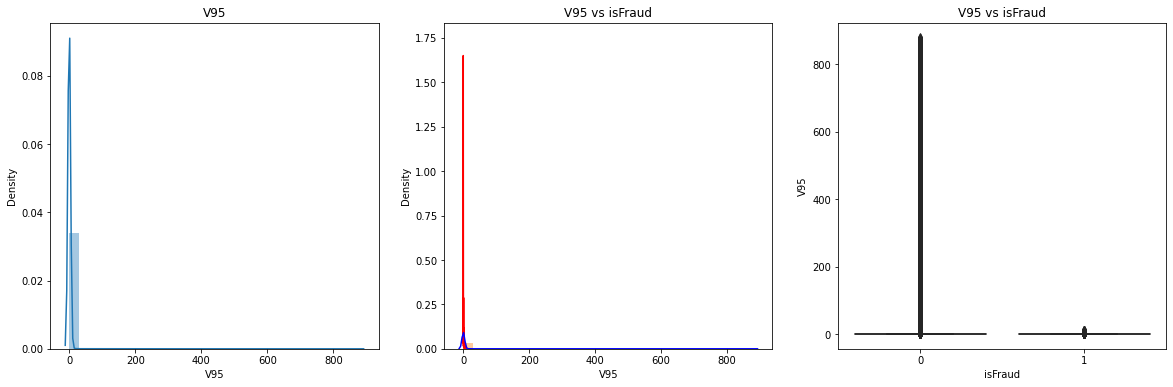

count    144169.000000
mean          7.429760
std          80.780593
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1410.000000
Name: V96, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

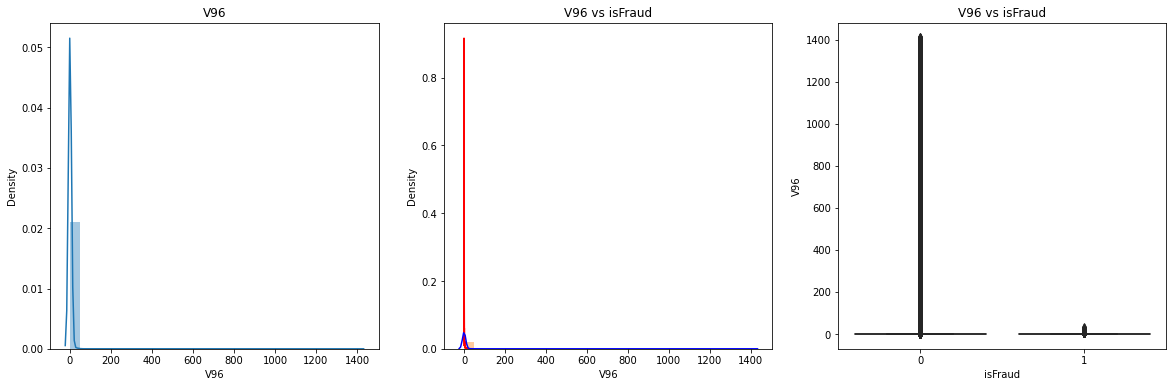

count    144169.000000
mean          5.235633
std          55.771274
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         976.000000
Name: V97, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

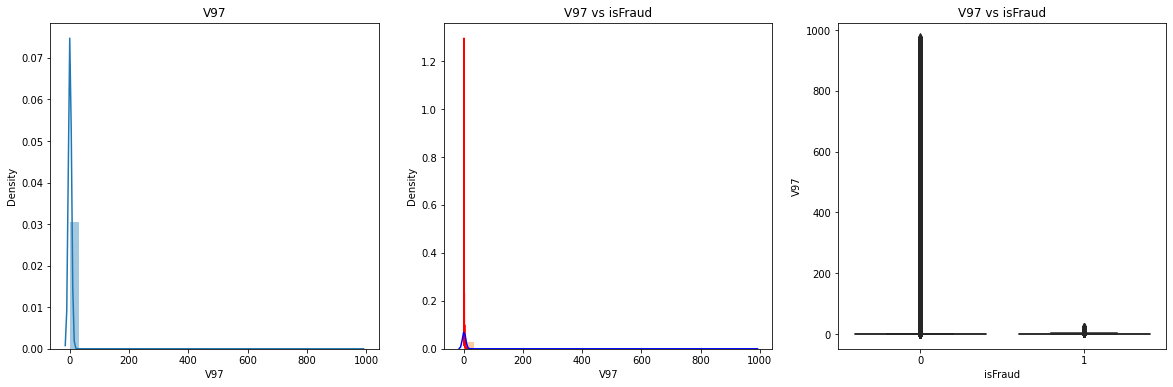

count    144169.000000
mean          0.032219
std           0.226304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V98, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

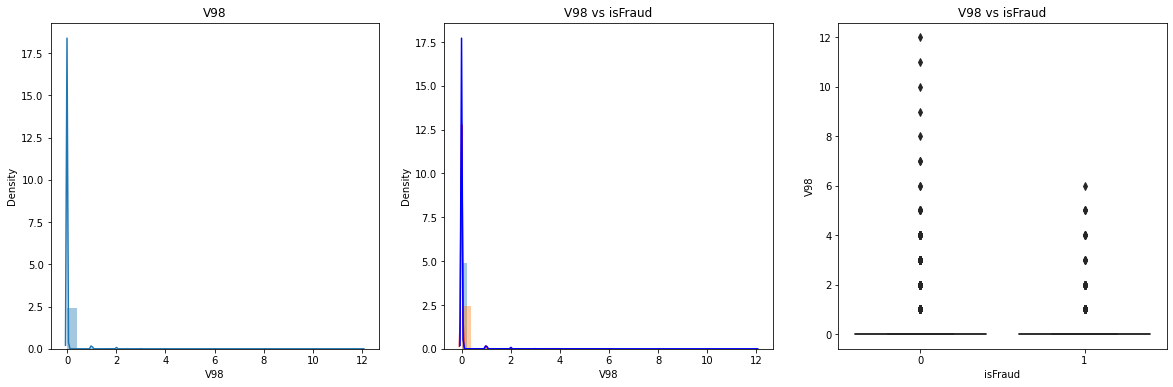

count    144169.000000
mean          0.450263
std           2.940506
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          43.000000
Name: V99, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

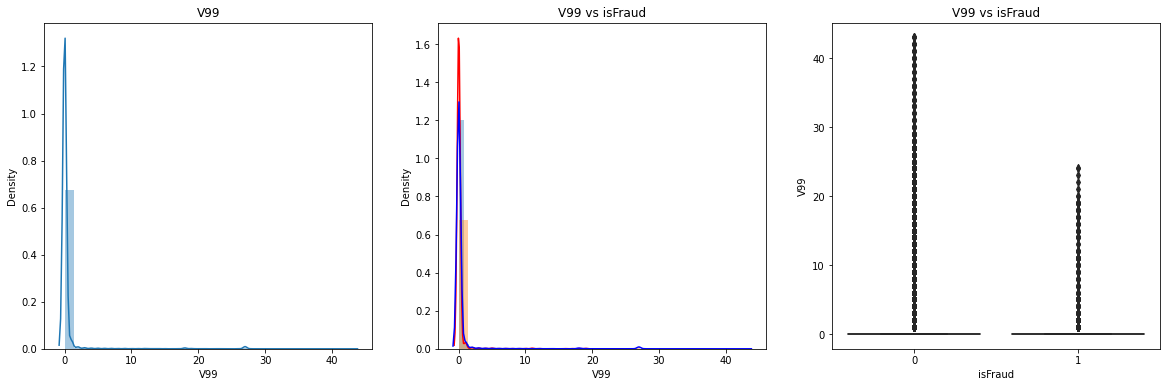

count    144169.000000
mean          0.159355
std           1.021986
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          17.000000
Name: V100, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

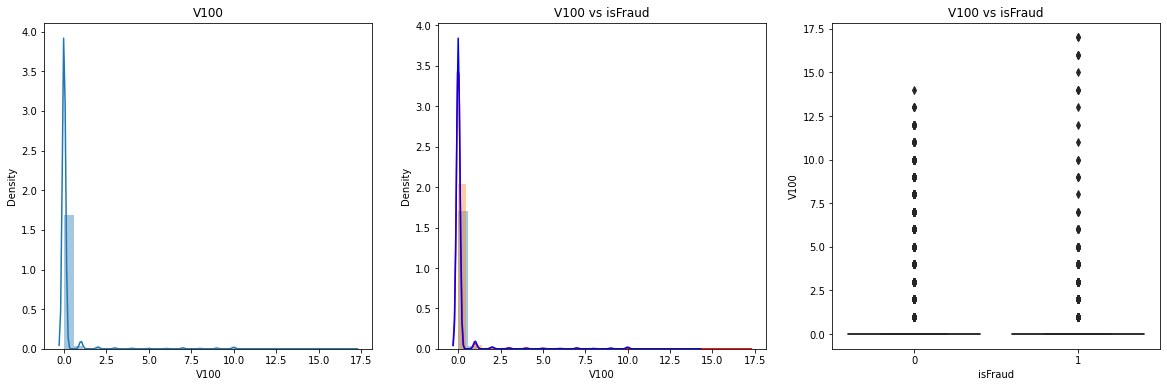

count    144169.000000
mean          3.338471
std          41.494225
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         869.000000
Name: V101, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

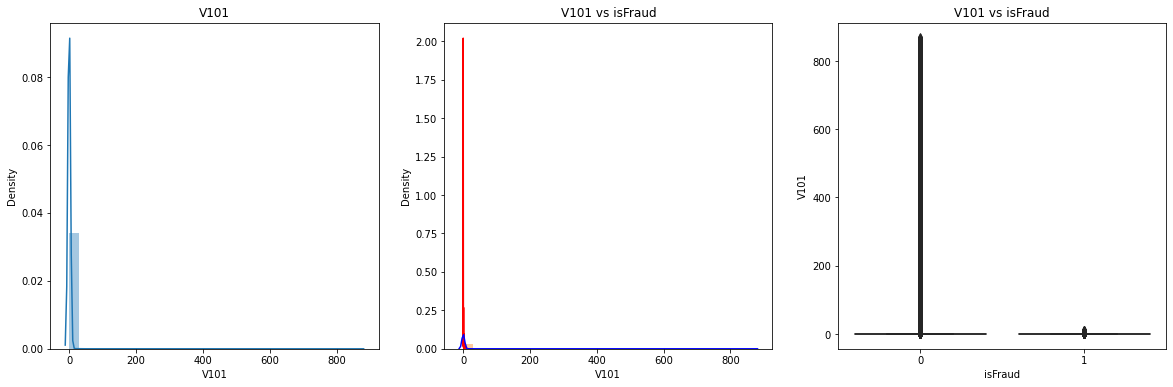

count    144169.000000
mean          6.237048
std          72.287288
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1285.000000
Name: V102, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

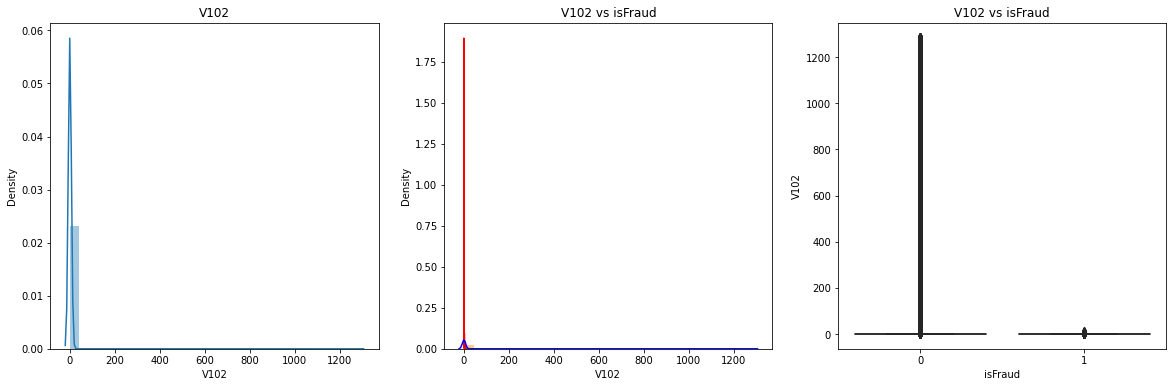

count    144169.000000
mean          4.636031
std          51.746309
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         928.000000
Name: V103, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

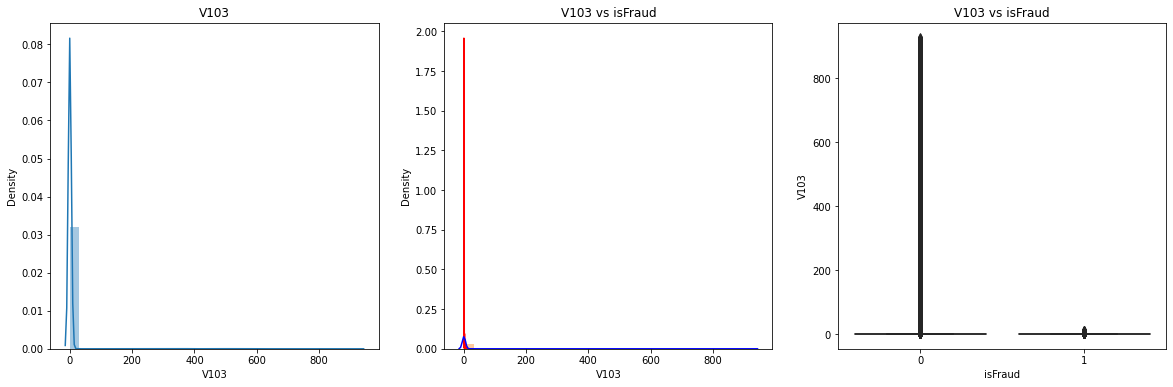

count    144169.000000
mean          0.187162
std           1.191219
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V104, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

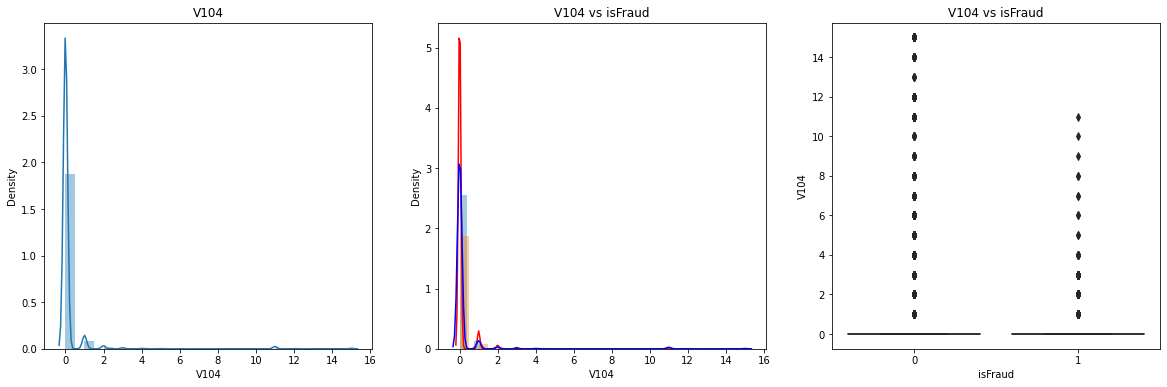

count    144169.000000
mean          0.735935
std           6.650123
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.000000
Name: V105, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

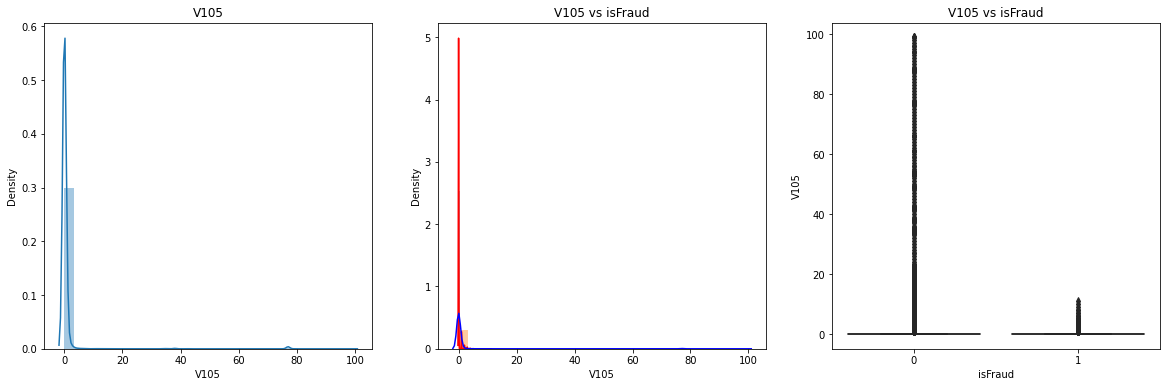

count    144169.000000
mean          0.434594
std           3.586018
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: V106, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

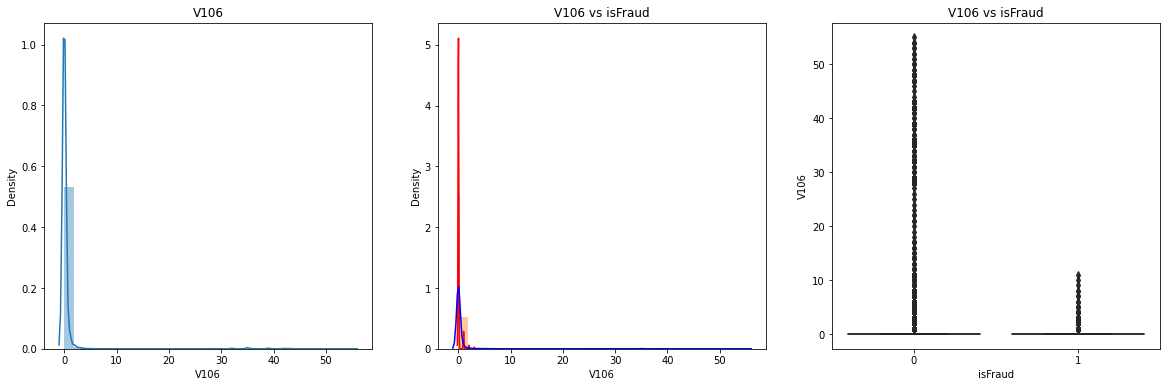

count    144169.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: V107, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate

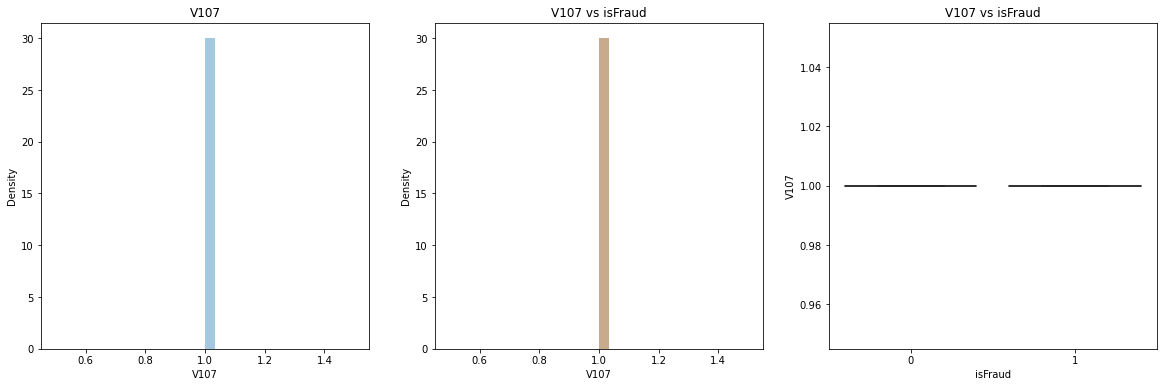

count    144169.000000
mean          1.008213
std           0.112551
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V108, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

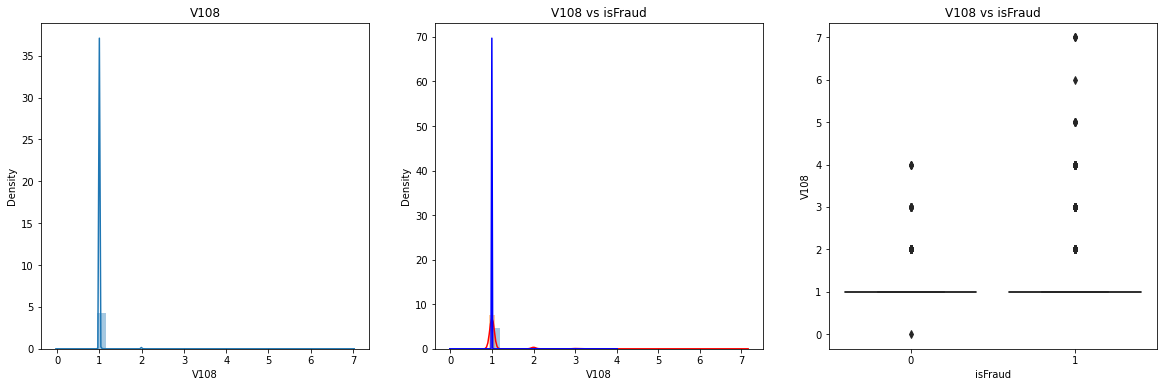

count    144169.000000
mean          1.008663
std           0.114503
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V109, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

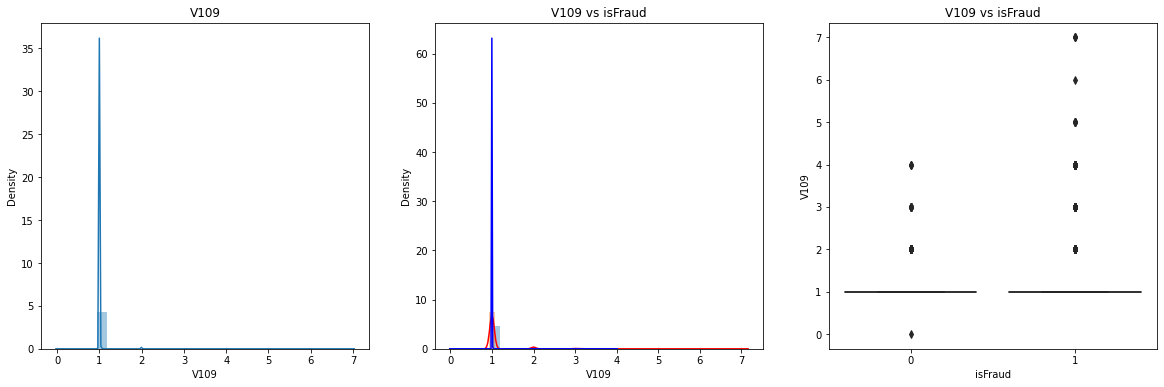

count    144169.000000
mean          1.008379
std           0.113276
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V110, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

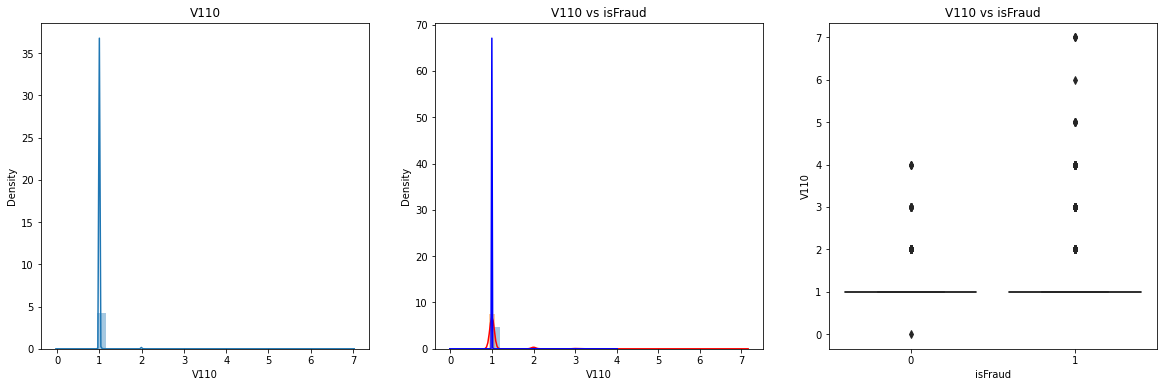

count    144169.000000
mean          1.009336
std           0.125742
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V111, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

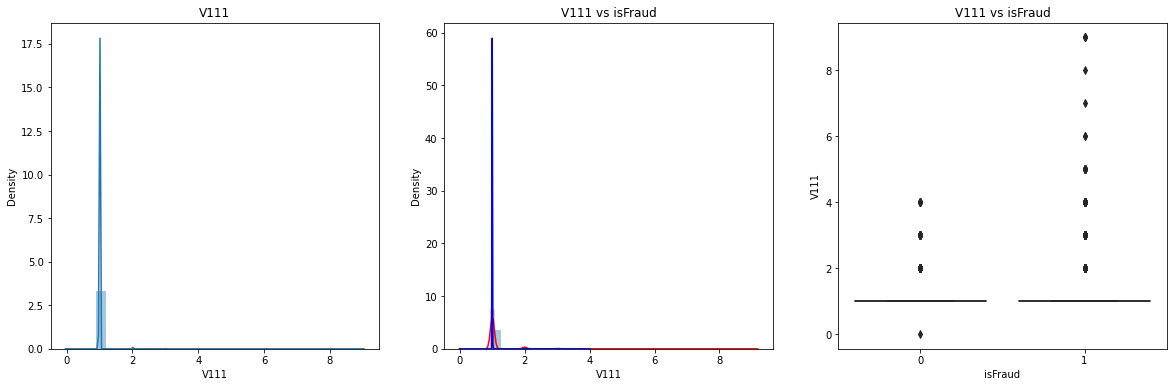

count    144169.000000
mean          1.009621
std           0.126901
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V112, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

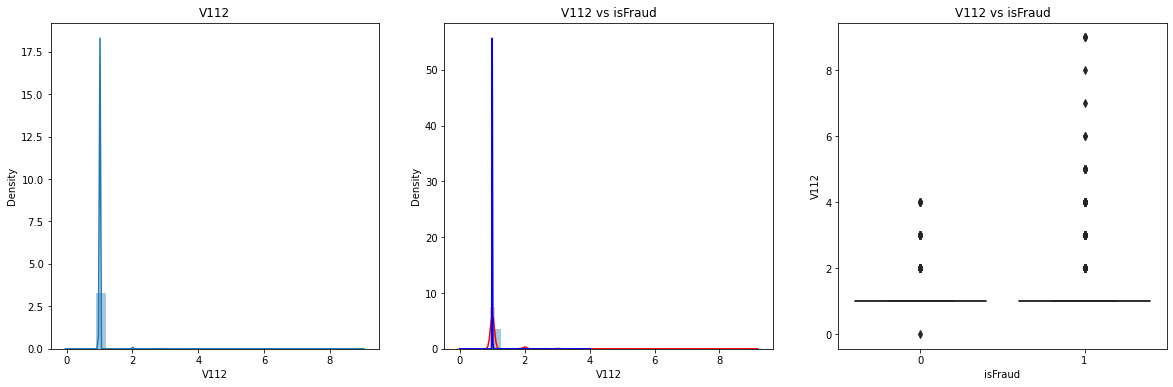

count    144169.000000
mean          1.009510
std           0.126471
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V113, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

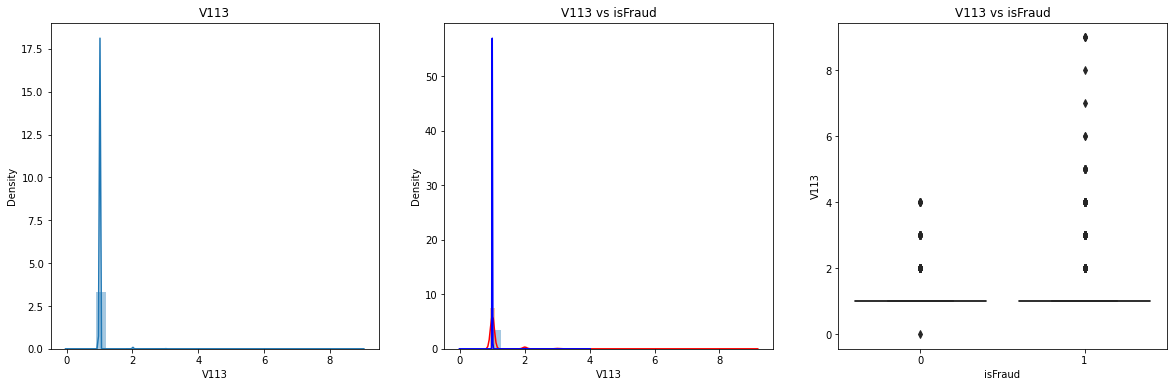

count    144169.000000
mean          1.015100
std           0.148801
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V114, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

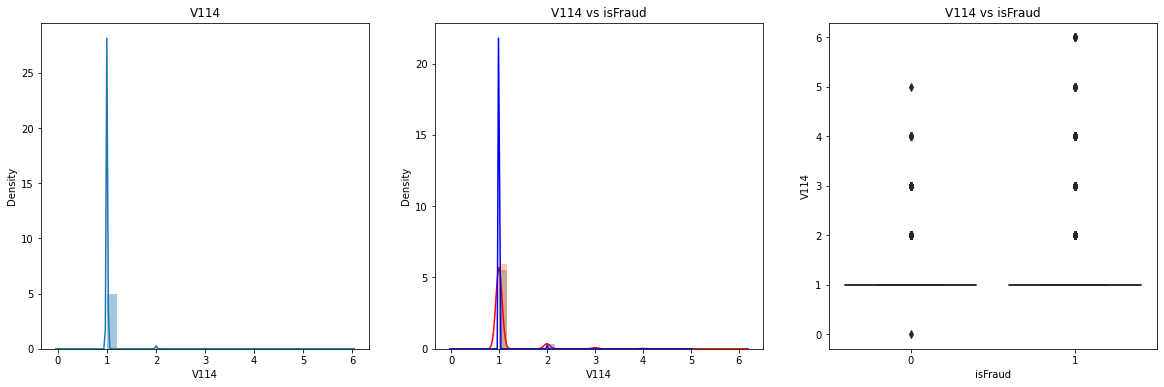

In [42]:
for i in range(20):
  varc='V'+str(i+95)
  #Apercu générale sur la variable
  print(train[varc].describe())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,3,1)
  sns.distplot(train[varc],bins=30)
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,3,2)
  sns.distplot(train[train['isFraud']==1][varc],bins=30,kde_kws={"color": "r"},label=varc+'Fraude')
  sns.distplot(train[train['isFraud']==0][varc],bins=30,kde_kws={"color": "b"},label=varc+'Nofraude')
  plt.title(varc +' vs isFraud')

  plt.subplot(1,3,3)
  sns.boxplot(x='isFraud', y=varc,data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()


* **Card4**

visa                89299
mastercard          44186
american express     8298
discover             2266
Name: card4, dtype: int64


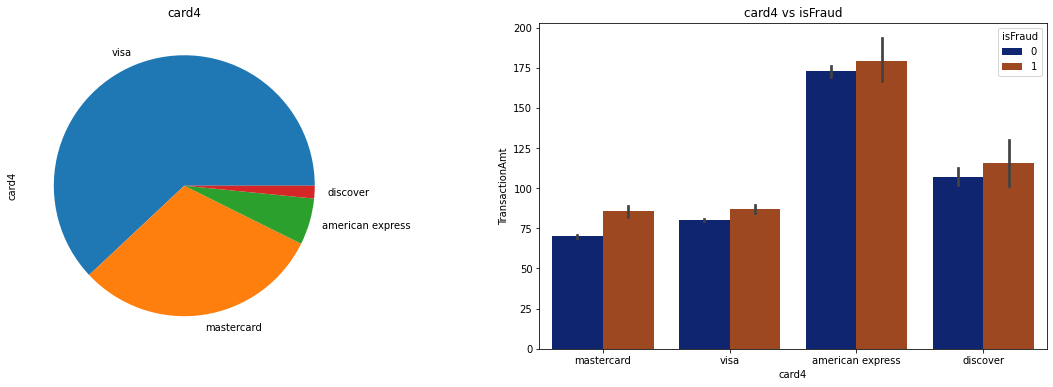

In [43]:
varc='card4'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()



* **ProbuctCD**

C    62192
R    37548
H    32908
S    11585
Name: ProductCD, dtype: int64


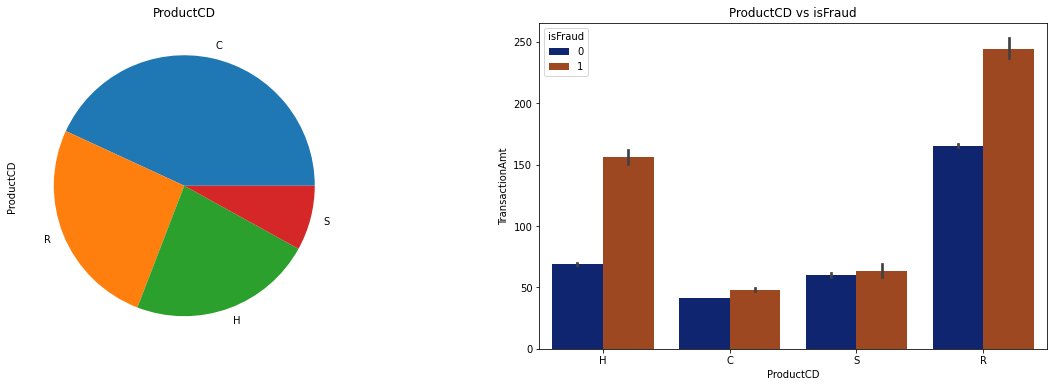

In [44]:
varc='ProductCD'
#Apercu générale sur la variable
print(train[varc].value_counts())

plt.figure(figsize=(20,6))

#Distribution de la variable
plt.subplot(1,2,1)
train[varc].value_counts(normalize=True).plot(kind='pie')
plt.title(varc)

#Distribution de la variable suivant le caractère frauduleux 
plt.subplot(1,2,2)
sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
plt.title(varc+' vs isFraud')
plt.show()

* **Features id quantitatif**

NotFound    123025
Found        21208
Name: id_12, dtype: int64


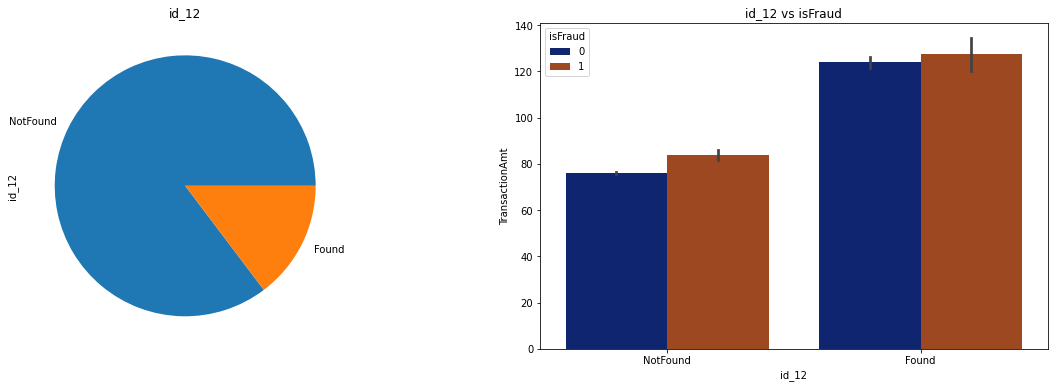

Found      67728
New        61612
Unknown    11645
Name: id_15, dtype: int64


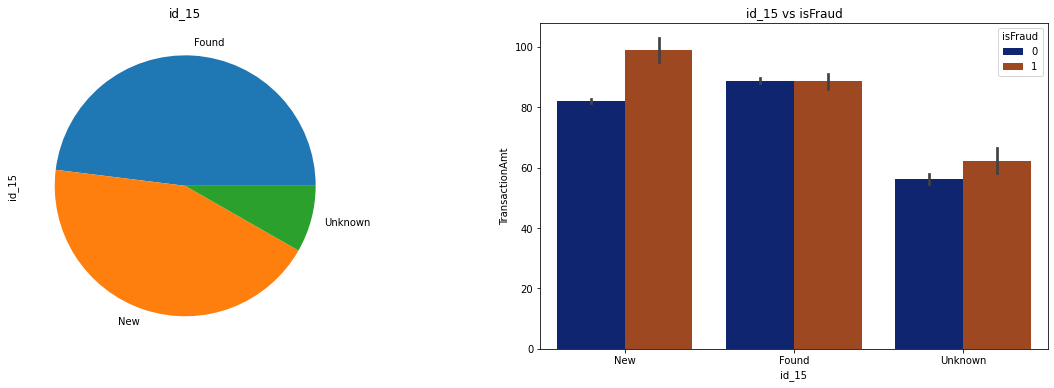

Found       66324
NotFound    63016
Name: id_16, dtype: int64


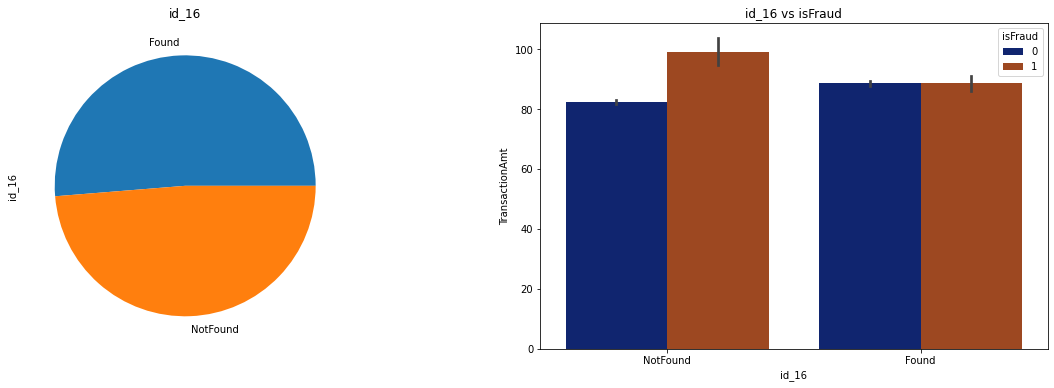

Found    76232
New      64746
Name: id_28, dtype: int64


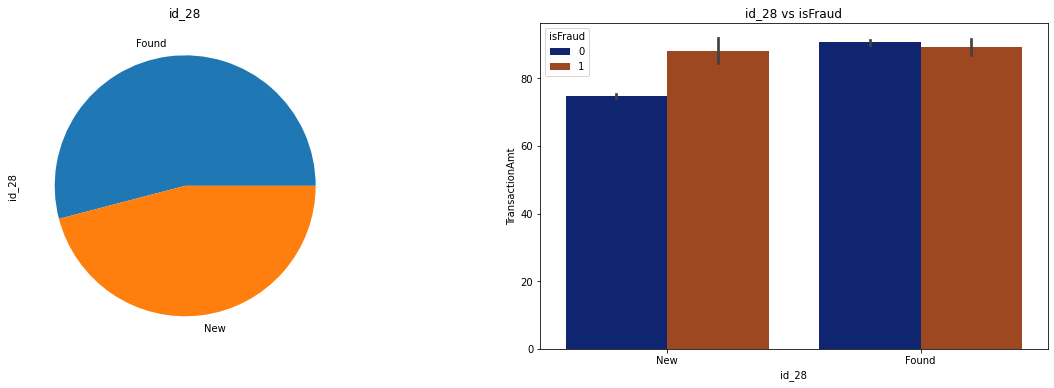

Found       74926
NotFound    66052
Name: id_29, dtype: int64


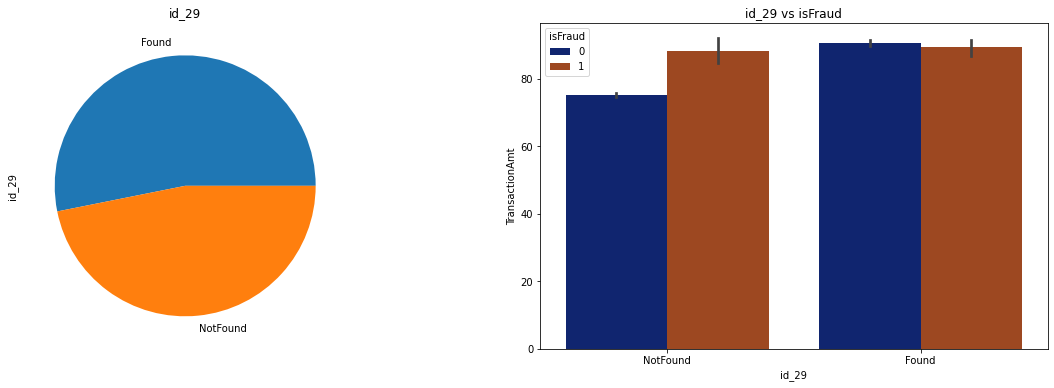

T    77814
F    63171
Name: id_35, dtype: int64


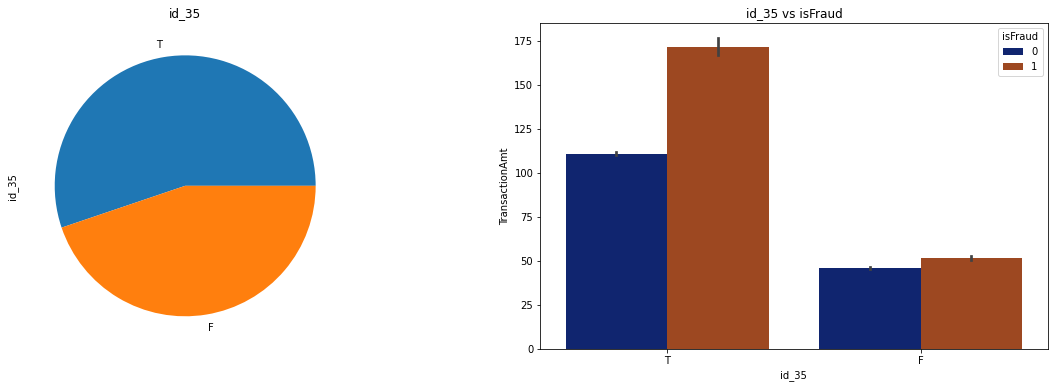

F    134066
T      6919
Name: id_36, dtype: int64


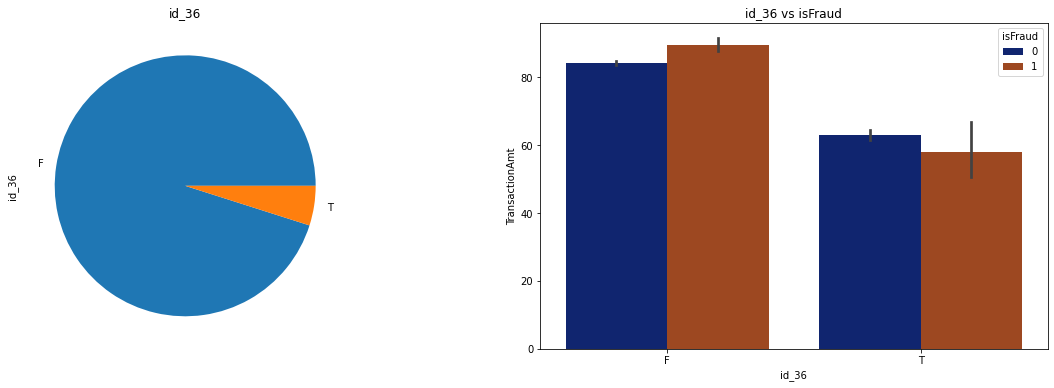

T    110452
F     30533
Name: id_37, dtype: int64


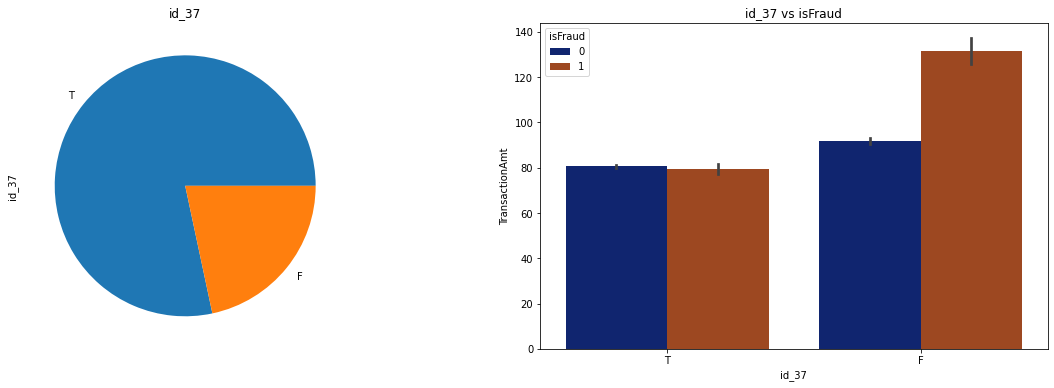

F    73922
T    67063
Name: id_38, dtype: int64


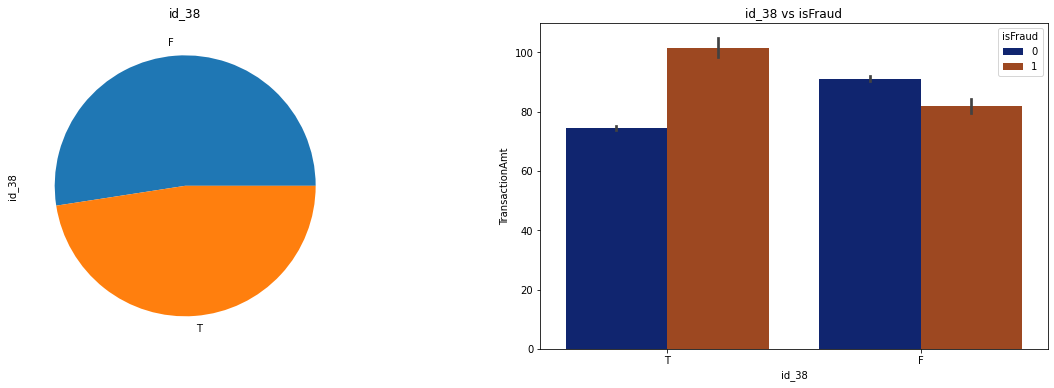

In [45]:
for i in (12,15,16,28,29,35,36,37,38):
  varc='id_'+str(i)
  #Apercu générale sur la variable
  print(train[varc].value_counts())

  plt.figure(figsize=(20,6))

  #Distribution de la variable
  plt.subplot(1,2,1)
  train[varc].value_counts(normalize=True).plot(kind='pie')
  plt.title(varc)

  #Distribution de la variable suivant le caractère frauduleux 
  plt.subplot(1,2,2)
  sns.barplot(x=varc,y='TransactionAmt',hue='isFraud',data=train,palette='dark')
  plt.title(varc+' vs isFraud')
  plt.show()



On constate de facon générales que les features presentes des valeurs abérrantes. Pour eviter que ces dernières impactes négativements nos modèles, nous allons procéder à une detection de ces valeurs abérrantes puis nous allons les traiter comme des valeurs manquantes de notre base de données.

## Pré-traitement des données

### **Détection des valeurs manquantes**

In [46]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [47]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


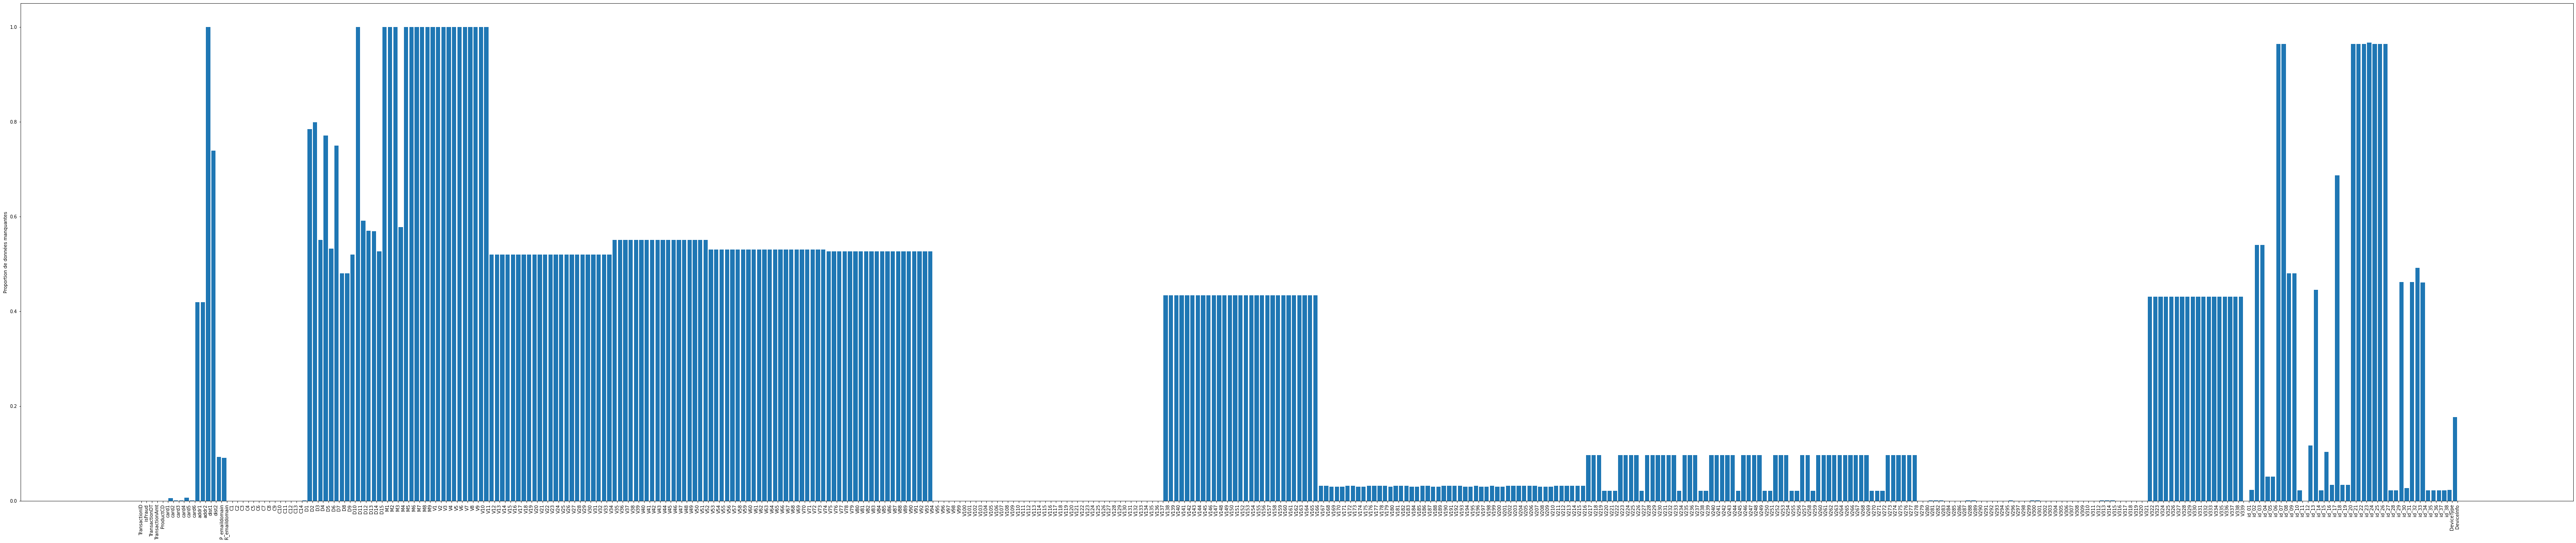

In [48]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

### **Analyse de la variable d'intérêt**

In [49]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

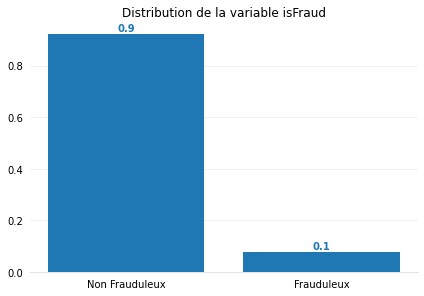

In [50]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [51]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

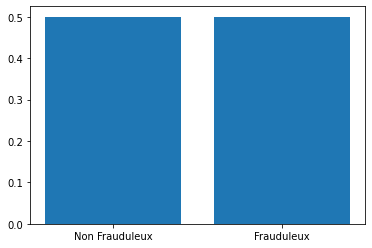

In [52]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

### **Visualisation des données manquantes dans la base recalibré**

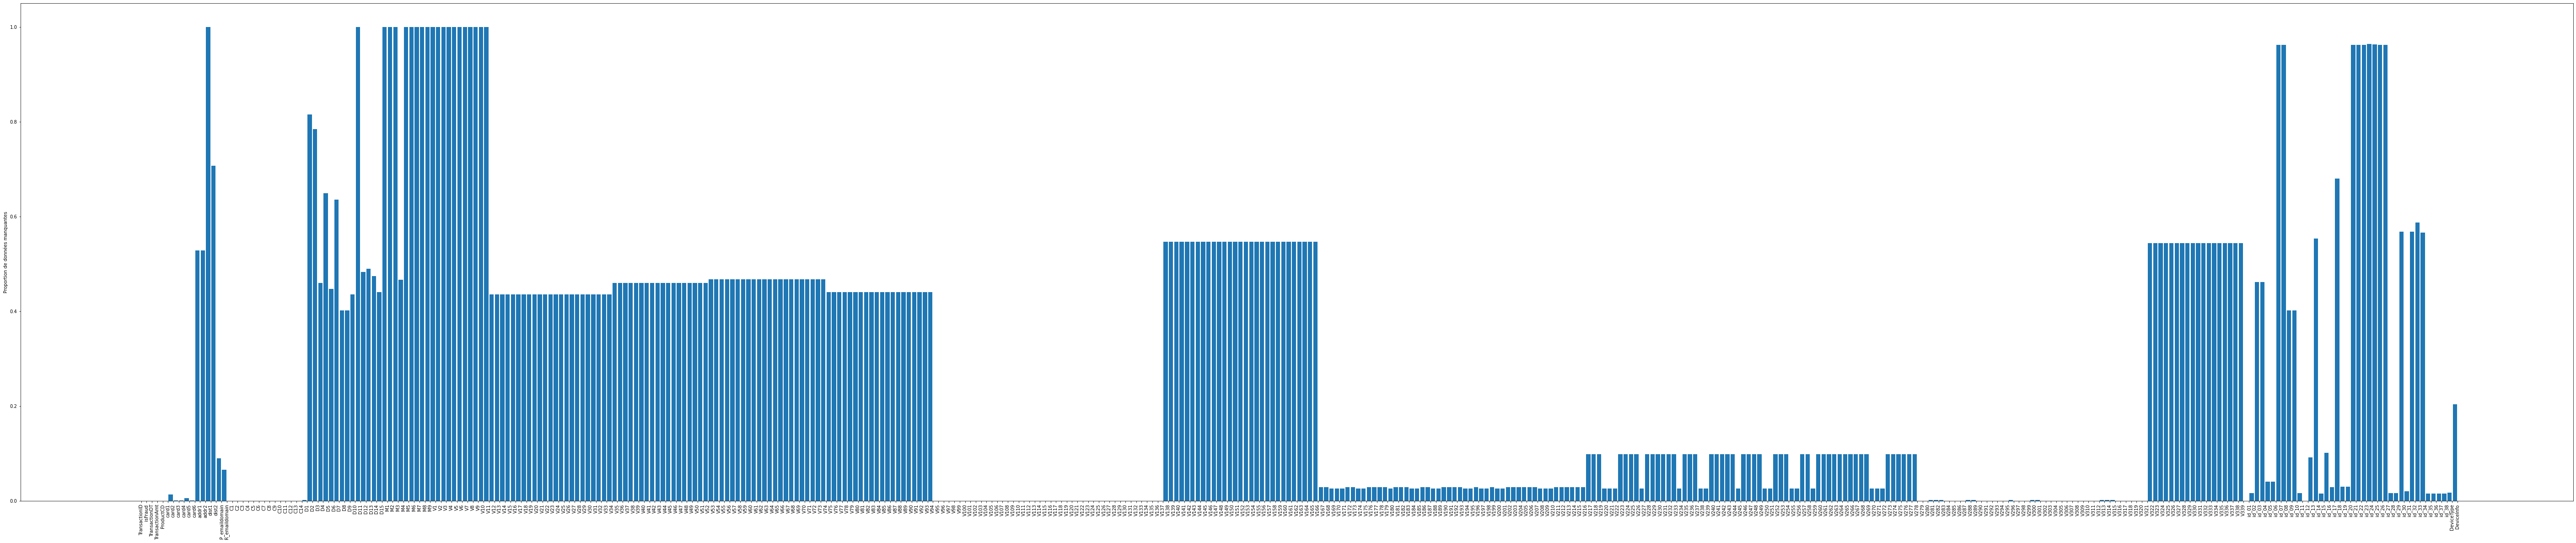

In [53]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

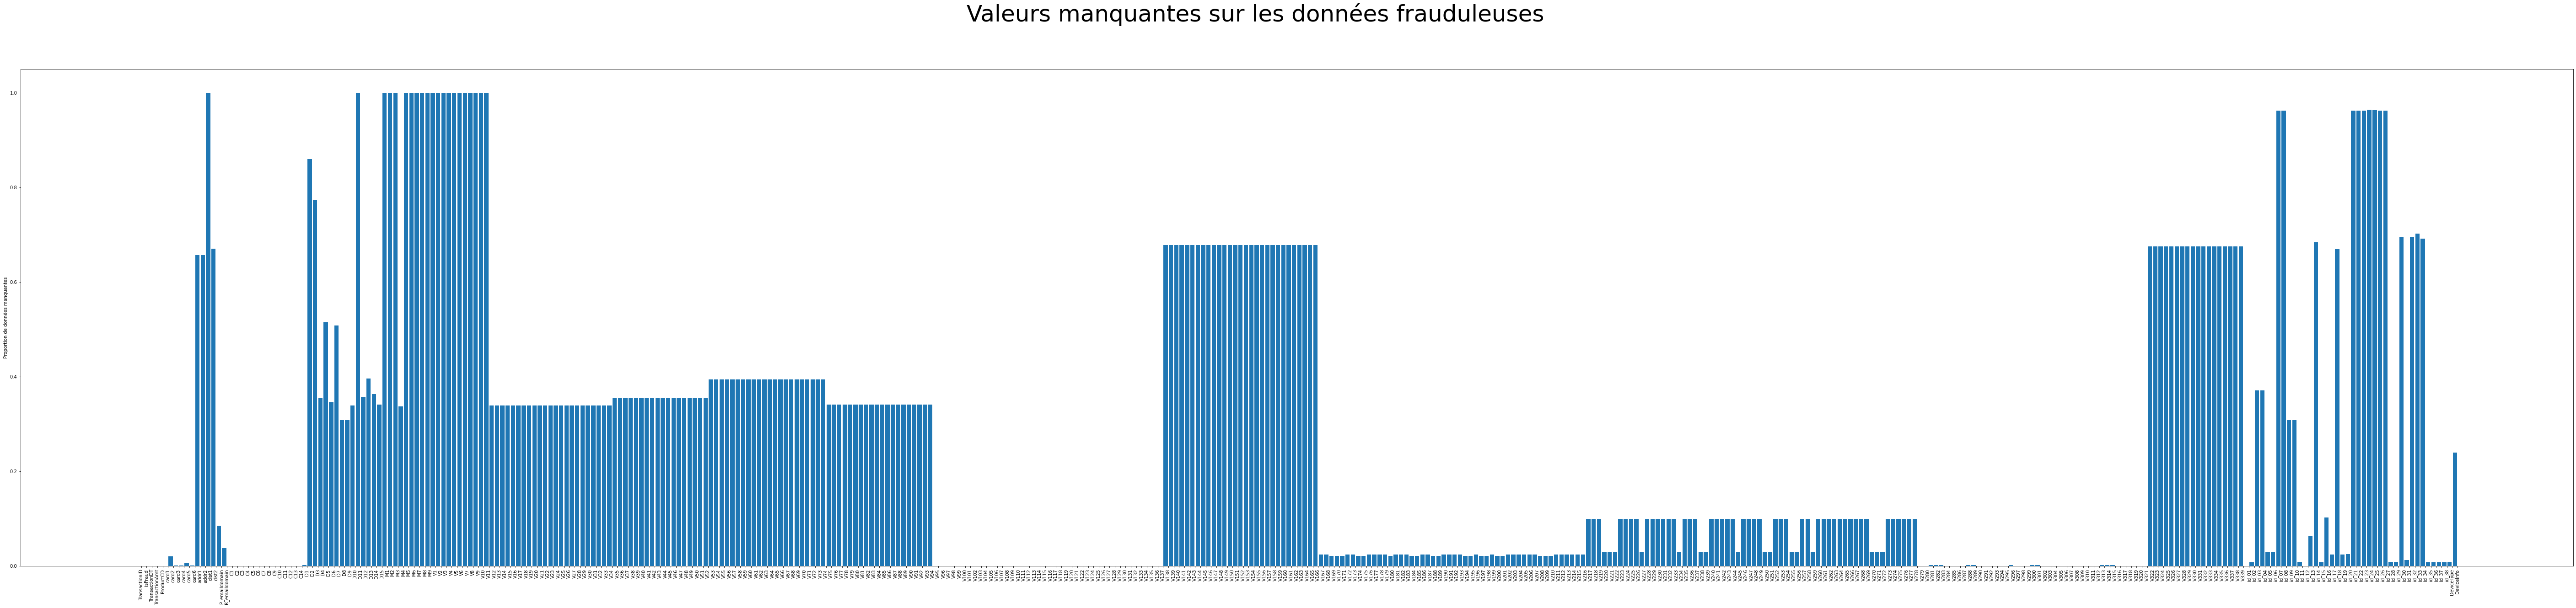

In [54]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

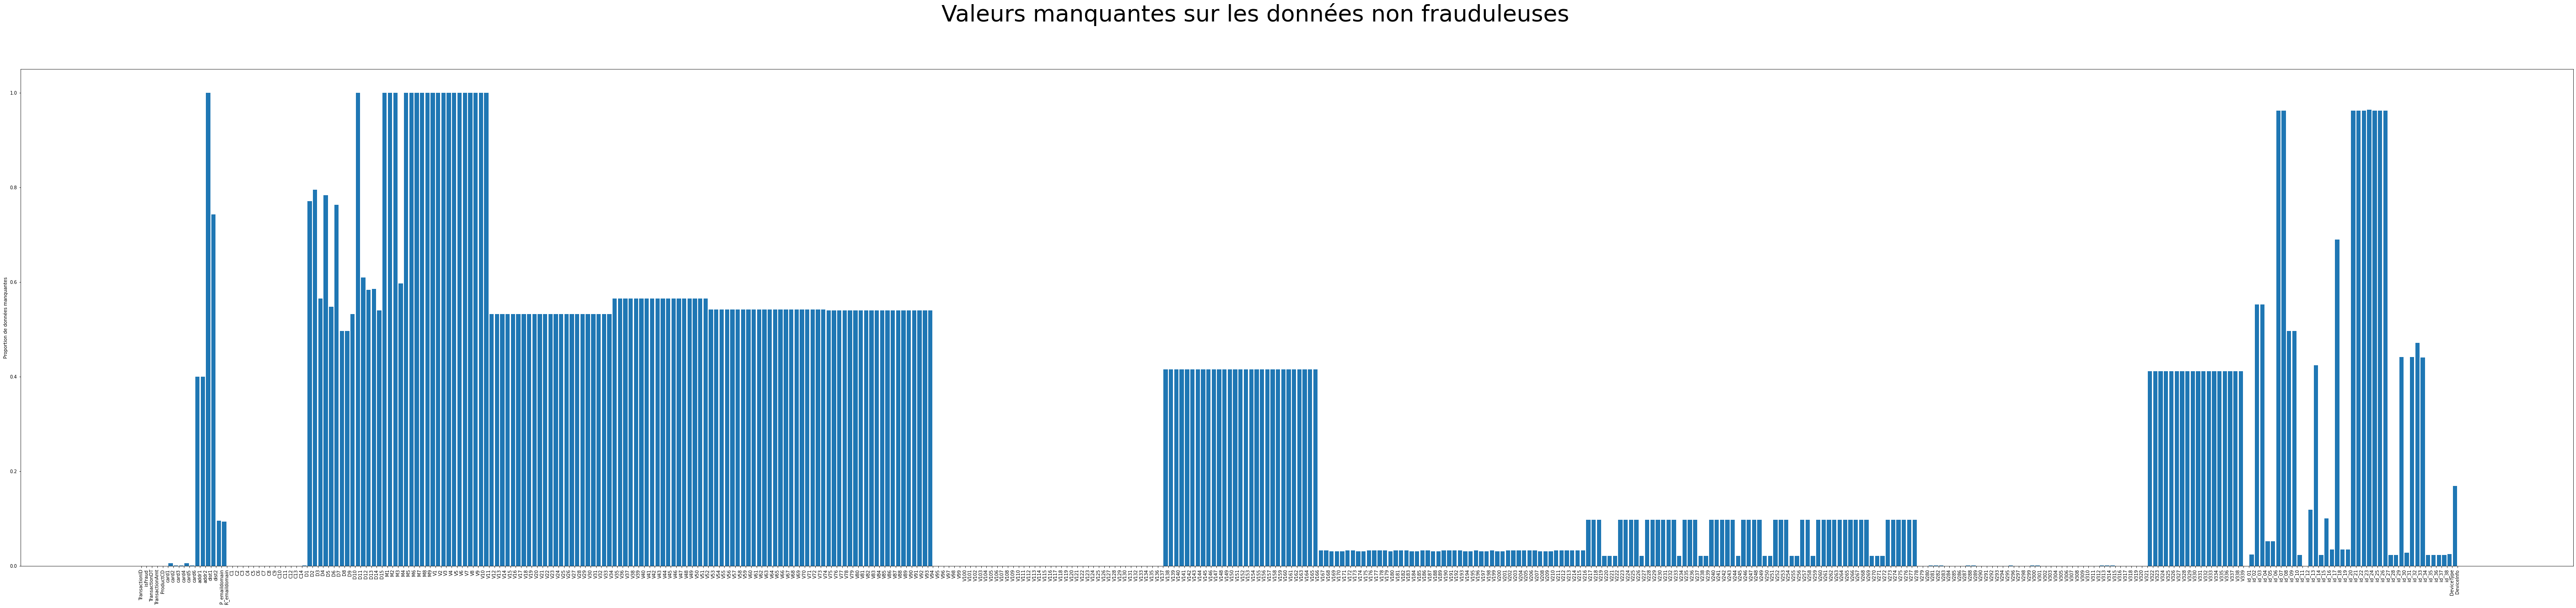

In [55]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [56]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


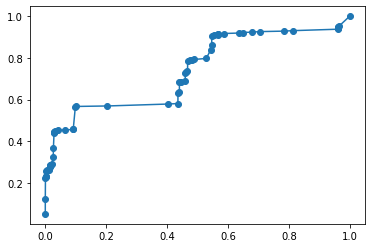

In [57]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

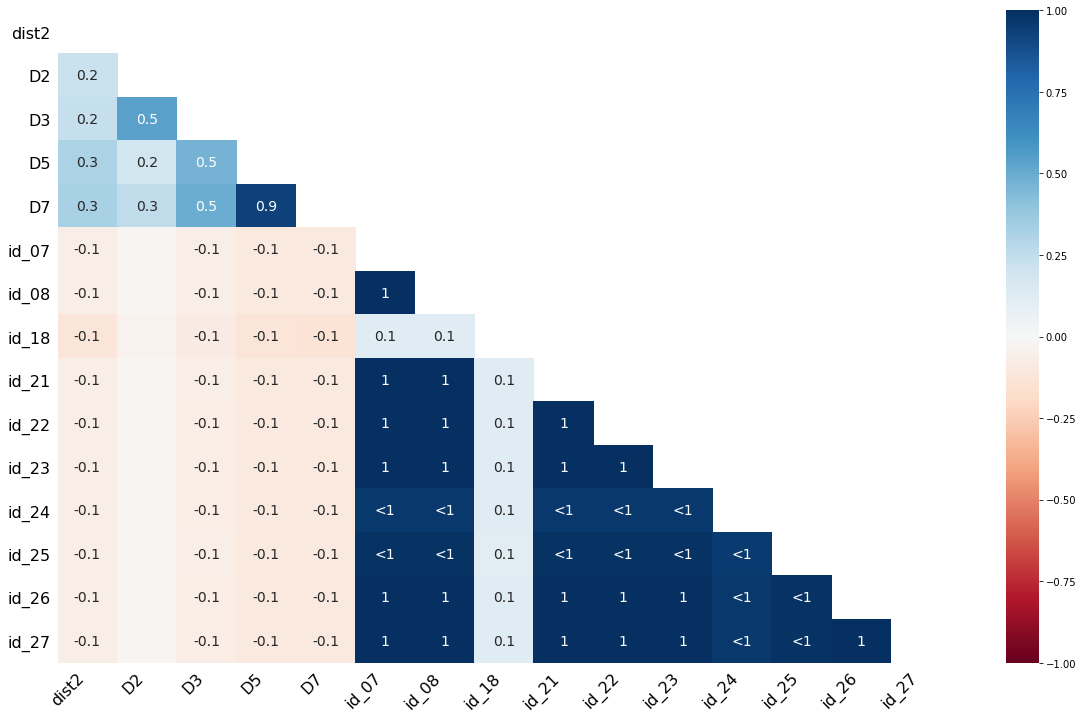

In [58]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [59]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)


Valeur manquante en utilisant  Multivariate Imputation by Chained Equation (MICE) [Mice](https://www.jstatsoft.org/article/view/v045i03)

In [60]:
"""
from impyute.imputation.cs import mice
from datetime import datetime
start_time = datetime.now()
train_imputed1=mice(train_work.select_dtypes(exclude='object').values)
end_time = datetime.now()
time_mice=end_time-start_time
"""

"\nfrom impyute.imputation.cs import mice\nfrom datetime import datetime\nstart_time = datetime.now()\ntrain_imputed1=mice(train_work.select_dtypes(exclude='object').values)\nend_time = datetime.now()\ntime_mice=end_time-start_time\n"

In [61]:
#train_imputed1

In [62]:
from sklearn.impute import KNNImputer
tps1 = time.clock()
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))
tps2 = time.clock()
time_treatment_var_manquant_KNN = tps2-tps1
print('Temps execution du traitement des valeurs manquantes:', tps2-tps1)

Temps execution du traitement des valeurs manquantes: 275.99235


In [63]:
train_imputed

array([[2.9871410e+06, 0.0000000e+00, 8.8755000e+04, ..., 1.6600000e+02,
        6.5000000e+02, 5.9700000e+02],
       [2.9872360e+06, 0.0000000e+00, 9.0149000e+04, ..., 1.6600000e+02,
        3.9000000e+02, 5.4900000e+02],
       [2.9872400e+06, 1.0000000e+00, 9.0193000e+04, ..., 2.2500000e+02,
        2.6600000e+02, 3.2500000e+02],
       ...,
       [3.5774450e+06, 0.0000000e+00, 1.5809497e+07, ..., 1.6600000e+02,
        5.2900000e+02, 5.4900000e+02],
       [3.5775060e+06, 0.0000000e+00, 1.5810402e+07, ..., 1.6600000e+02,
        5.2900000e+02, 2.2200000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [64]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987141.0,0.0,88755.0,200.000,8194.0,325.0,150.0,195.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,110477.0,0.0,-5.0,95.650002,49.0,166.0,650.0,597.0,R,visa,debit,anonymous.com,anonymous.com,NotFound,New,NotFound,Found,Found,safari generic,T,F,F,F,desktop
1,2987236.0,0.0,90149.0,30.000,10023.0,111.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,52546.0,0.0,0.0,100.000000,49.0,166.0,390.0,549.0,H,visa,debit,yahoo.com,gmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987240.0,1.0,90193.0,37.098,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169947.0,3.0,0.0,100.000000,38.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
3,2987243.0,1.0,90246.0,37.098,13413.0,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222455.0,0.0,0.0,100.000000,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
4,2987245.0,1.0,90295.0,37.098,13413.0,103.0,185.0,137.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271870.0,3.0,0.0,100.000000,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577368.0,1.0,15807677.0,100.000,6758.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.013200,12.013200,12.013200,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,214747.0,0.0,0.0,100.000000,27.0,166.0,492.0,225.0,H,american express,credit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
22632,3577384.0,0.0,15807984.0,50.000,7005.0,111.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,50886.0,13.0,-34.0,100.000000,15.0,166.0,317.0,222.0,H,visa,debit,me.com,gmail.com,NotFound,Found,Found,Found,Found,mobile safari 11.0,T,F,T,T,mobile
22633,3577445.0,0.0,15809497.0,500.000,6019.0,583.0,150.0,226.0,6.0,6.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0

### **Analyse et traitement des valeurs aberrantes**

**Détection des valeurs aberrantes**

In [65]:
#detection des valeurs aberrantes
def replace_VA(df_in, col_name):
       q1 = df_in[col_name].quantile(0.25)
       q3 = df_in[col_name].quantile(0.75)
       iqr = q3-q1 #Interquartile range
       fence_low  = q1-1.5*iqr
       fence_high = q3+1.5*iqr
       for i in range(len(df_in[col_name])):
          if df_in[col_name][i]!='NaN':
            if df_in[col_name][i]< fence_low or df_in[col_name][i]>fence_high:
              df_in[col_name][i]=np.NaN

In [66]:
train_imputed['TransactionID']=train_imputed['TransactionID'].astype(int)
df=train_imputed.select_dtypes(exclude='object')
df_object=train_imputed.select_dtypes(exclude='float64')


In [67]:
#traitement des valeurs manquantes 
tps1 = time.clock()
for i in range(3,len(df.columns)):
  varc=df.columns[i]
  replace_VA(df, varc)
tps2 = time.clock()
print('Temps de remplacement des valeurs aberrantes en NaN', tps2-tps1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Temps de remplacement des valeurs aberrantes en NaN 308.96854300000007


In [68]:
#Base de données après traitement des valeurs aberrantes 
train_imputed=pd.merge(df,df_object,on="TransactionID",how="right")

In [69]:
#On utilise le KNN précedent pour traiter les NaN créés
tps1 = time.clock()
df_ok = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(df)
df_ok = pd.DataFrame(df_ok)
df_ok.columns = df.columns
tps2 = time.clock()
time_treatment_var_aberrant = tps2-tps1
print('Temps execution des valeurs aberrantes:', tps2-tps1)

Temps execution des valeurs aberrantes: 859.6887989999999


In [70]:
#Base de données après traitement des valeurs aberrantes 
train_imputed=pd.merge(df_ok,df_object,on="TransactionID",how="right")

In [71]:
train_imputed 

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987141.0,0.0,88755.0,200.0000,8194.0,325.0,150.0,195.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,110477.0,0.0,-5.0,100.0,49.00,166.0,650.0,597.0,R,visa,debit,anonymous.com,anonymous.com,NotFound,New,NotFound,Found,Found,safari generic,T,F,F,F,desktop
1,2987236.0,0.0,90149.0,30.0000,10023.0,111.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,52546.0,0.0,0.0,100.0,49.00,166.0,390.0,549.0,H,visa,debit,yahoo.com,gmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
2,2987240.0,1.0,90193.0,37.0980,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169947.0,0.0,0.0,100.0,38.00,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
3,2987243.0,1.0,90246.0,37.0980,13413.0,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222455.0,0.0,0.0,100.0,43.00,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
4,2987245.0,1.0,90295.0,37.0980,13413.0,103.0,185.0,137.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,271870.0,0.0,0.0,100.0,43.00,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577368.0,1.0,15807677.0,100.0000,6758.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,214747.0,0.0,0.0,100.0,52.00,166.0,492.0,225.0,H,american express,credit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
22632,3577384.0,0.0,15807984.0,50.0000,7005.0,111.0,150.0,226.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,50886.0,0.2,-0.4,100.0,52.00,166.0,317.0,222.0,H,visa,debit,me.com,gmail.com,NotFound,Found,Found,Found,Found,mobile safari 11.0,T,F,T,T,mobile
22633,3577445.0,0.0,15809497.0,31.1664,6019.0,583.0,150.0,226.0,6.0,6.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,107251.0,0.0,0.0,100.0,48.48,166.0,529.0,549.0,H,visa,credit,gmail.com,N

### **Traitement des variables qualitatives**

In [73]:
# Nombre de modalités par variable
train_imputed.select_dtypes('object').nunique()

ProductCD          4
card4              4
card6              3
P_emaildomain     58
R_emaildomain     59
id_12              2
id_15              3
id_16              2
id_28              2
id_29              2
id_31            107
id_35              2
id_36              2
id_37              2
id_38              2
DeviceType         2
dtype: int64

On remarque que certaines variables possèdent un nombre important de modalités, on va donc s'atteler à créer des méthodes automatiques de traitement textuel. Il s'agit de *P_emaildomain, R_emaildomain et de id_31*.

In [74]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))

gmail.com           10348
hotmail.com          4099
anonymous.com        2091
NaN                  2043
yahoo.com            1405
outlook.com           565
aol.com               438
comcast.net           219
icloud.com            192
yahoo.com.mx          110
outlook.es             89
msn.com                86
live.com.mx            86
live.com               78
verizon.net            77
me.com                 69
sbcglobal.net          61
bellsouth.net          48
att.net                46
mail.com               46
cox.net                45
hotmail.es             39
mac.com                33
protonmail.com         28
optonline.net          28
ymail.com              27
hotmail.fr             26
charter.net            25
yahoo.fr               22
prodigy.net.mx         19
web.de                 18
earthlink.net          17
gmx.de                 15
twc.com                 6
frontier.com            6
cfl.rr.com              5
suddenlink.net          5
q.com                   5
embarqmail.c

Un traitement efficace et simple serait de retirer les extensions afin de ne conserver que les noms de domaines.

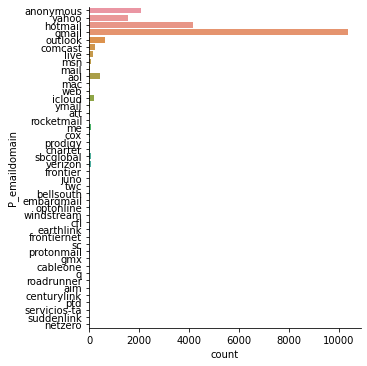

In [75]:
train_imputed['P_emaildomain'] = train_imputed['P_emaildomain'].str.split('.').str.get(0)
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On décide aussi finalement de regrouper les modalités non significatives dans une modalité autre.

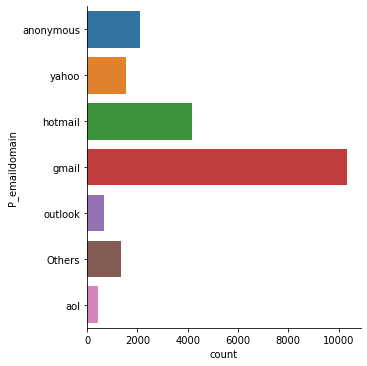

In [76]:
#On regroupe les modalités peu significatives dans autres
prop = train_imputed['P_emaildomain'].value_counts()/len(train_imputed)
train_imputed['P_emaildomain'] = np.where(train_imputed['P_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['P_emaildomain'])
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

On procède à un taitement similaire pour la variable *R_emaildomain* étant donné qu'elle se présente sous le même format.

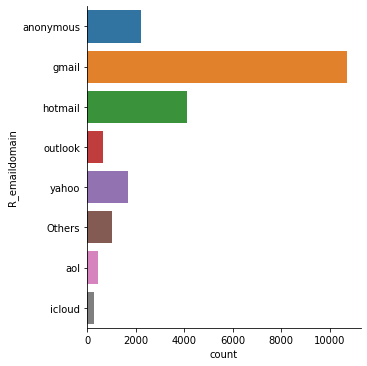

In [77]:
train_imputed['R_emaildomain'] = train_imputed['R_emaildomain'].str.split('.').str.get(0)
prop = train_imputed['R_emaildomain'].value_counts()/len(train_imputed)
train_imputed['R_emaildomain'] = np.where(train_imputed['R_emaildomain'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed['R_emaildomain'])
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

In [78]:
#Traitement textuel de la variable sur les navigateurs
print(train_imputed['id_31'].value_counts(dropna=False))

chrome 63.0                       3229
mobile safari generic             2014
mobile safari 11.0                1922
chrome generic                    1201
chrome 65.0                       1178
chrome 64.0                       1104
chrome 63.0 for android           1103
ie 11.0 for desktop                925
chrome 62.0                        903
safari generic                     893
chrome 64.0 for android            822
chrome 65.0 for android            724
chrome 66.0                        715
chrome 66.0 for android            478
NaN                                471
edge 16.0                          456
firefox 57.0                       448
mobile safari 10.0                 353
chrome 62.0 for android            329
chrome generic for android         217
firefox                            189
firefox 59.0                       182
edge 15.0                          179
samsung browser 6.2                169
firefox 58.0                       145
chrome 61.0 for android  

En ce qui concerne le navigateur utiliser, on peut noter que l'existence de différentes versions entrainent l'existence de plusieurs modalités qui sont en réalité relatives à la même entité. On décide donc d'écrire un algorithme pour l'identification de similarité syntaxique et la labélisation.

Dans un premier temps, il s'agit d'identifier les similarités. Pour ce faire, on utilise la théorie des *ngrams* du *NLP (Natural Langage Processing)*. En particulier, vu le nombre peu important de mots par observations, on fera un **1gram**. On calcul alors un coefficient de ressemblance entre les modalités et on réalise un heatmap pour la visualisation. Enfin, on passe par une recherche sémantique des termes récurrents pour donner des labels aux modalités qui sont jugées similaires.

In [79]:
import re

def ngram(sentence, len_gram):
  """
    Fonction for splitting sentences into d-grammes
  """
  sentence = sentence.strip()
  sentence_split = re.split(r'[/\-,\s]\s*', sentence)
  words = [] 
  if len_gram >= len(sentence.split()) :
    sent_len = 1
  else :
    sent_len = len(sentence.split()) - len_gram +1
  for i in range(sent_len):
      words.append(sentence.split()[i:i+len_gram]) 
  return words

def diff_ngram(sent_a, sent_b, len_gram):
  """
    Fonction to evaluate correspondance between sentences
  """
  a = ngram(sent_a, len_gram)
  b = ngram(sent_b, len_gram) 
  cnt = 0 
  for i in a:
      for j in b:
          if i == j:
              cnt += 1
  return cnt/len(a)

def calculate_similarities(sentences):
  matrix_comparison = np.zeros((len(sentences), len(sentences)))
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      matrix_comparison[i][j] = diff_ngram(sentences[i], sentences[j], 1)
  mat = pd.DataFrame(matrix_comparison).set_index(sentences)
  mat.columns = sentences
  return mat

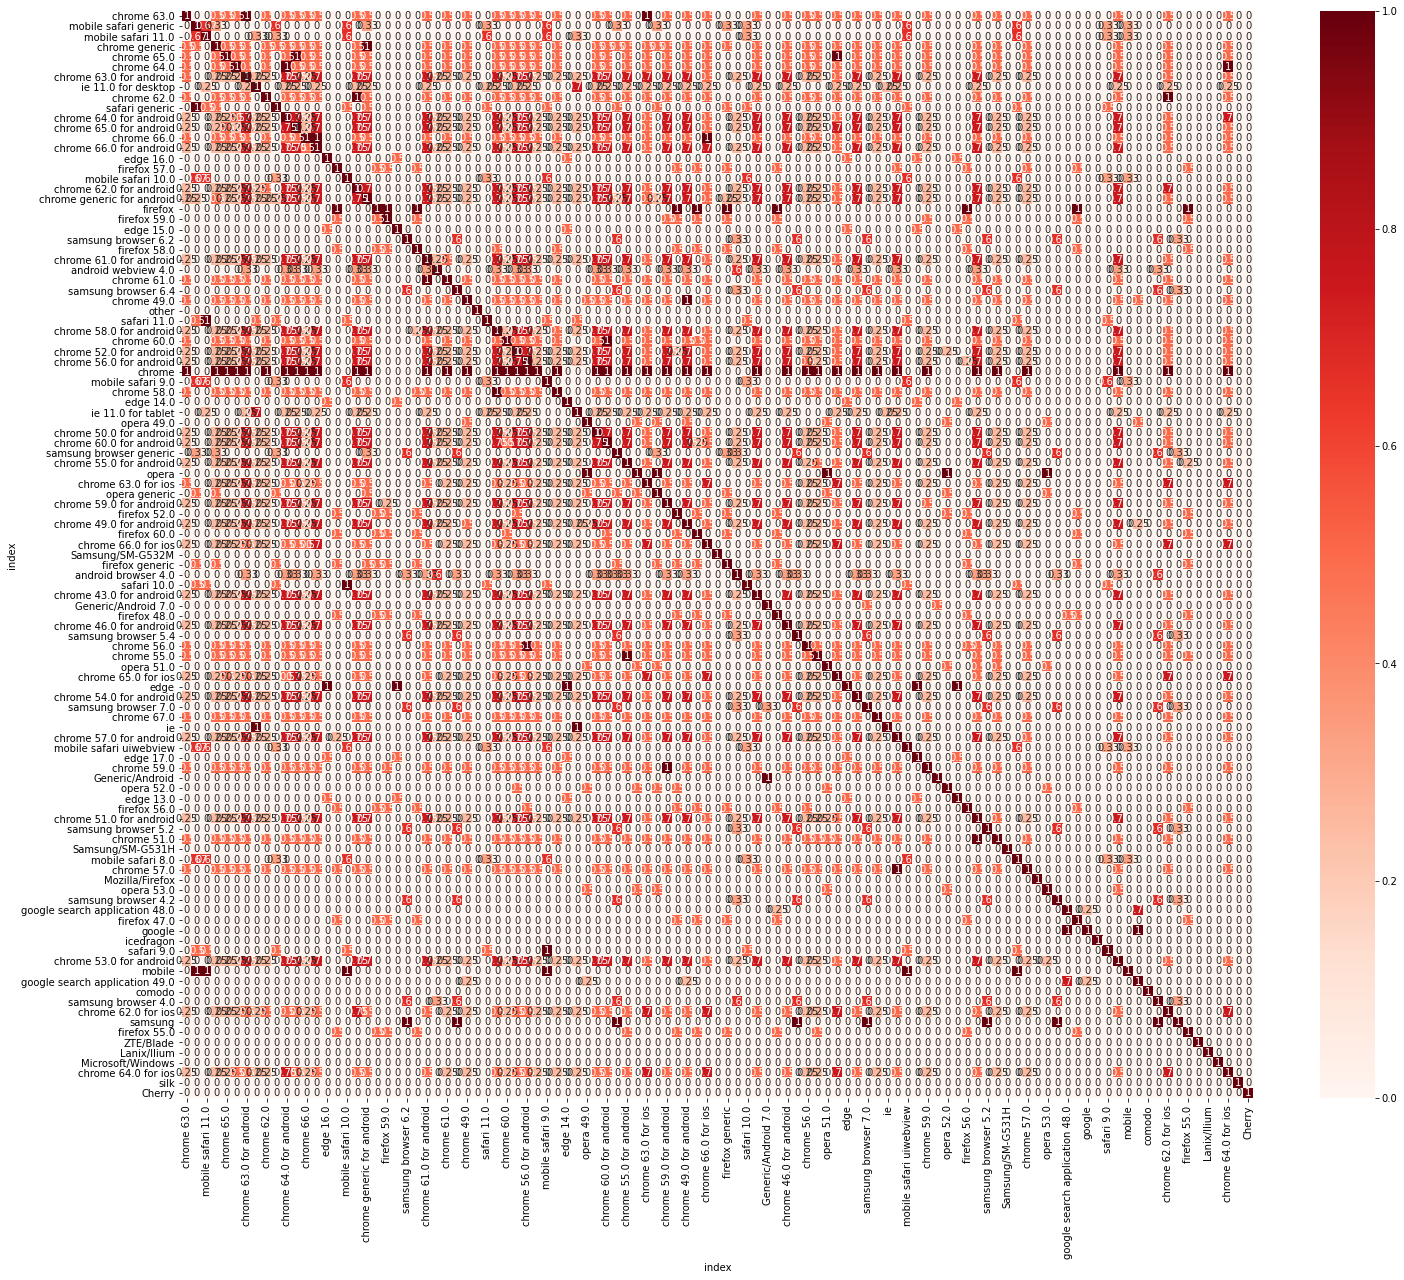

In [80]:
values = train_imputed['id_31'].value_counts().reset_index()['index']
mat = calculate_similarities(values)
plt.figure(figsize=(24,20))
sns.heatmap(mat, annot=True, cmap=plt.cm.Reds)
plt.show()

In [81]:
#Select the max per column
### First we replace on the diagonal the 1 value
i = 0
for var in mat.columns:
  mat[var][i] = 0
  i += 1
mod_list = list()
for var in mat.columns:
  tmp = mat[var][mat[var]>=0.75].reset_index()['index']
  tmp[len(tmp)] = var
  mod_list.append(np.array(tmp))

In [86]:
def common_words(text1, text2) :
  text1_words = text1.strip().split()
  text2_words = text2.strip().split()
  common = set(text1_words).intersection( set(text2_words) )
  text = ' '.join(common).strip()
  return text

In [87]:
prev_value = []
new_value = []

for elt in mod_list :
  if len(elt) > 1 :
    common_text = elt[0]
    for i in range(1,len(elt)) :
      common_text = common_words(common_text, elt[i])
    if common_text.strip() == "" :
      common_text = elt[-1]
    for val in elt :
      prev_value.append(val)
      new_value.append(common_text)

In [88]:
corr_mat = pd.DataFrame(prev_value,new_value).reset_index()
corr_mat.columns = ["New", "Prev"]
corr_mat = corr_mat.drop_duplicates('Prev')

In [89]:
train_imputed_b = pd.merge(train_imputed,corr_mat,how = 'left', left_on='id_31', right_on='Prev')
train_imputed_b['id_31'] = np.where(train_imputed_b['New'].isnull(),train_imputed_b['id_31'],train_imputed_b['New'])
train_imputed_b = train_imputed_b.drop(["New","Prev"], axis= 1)

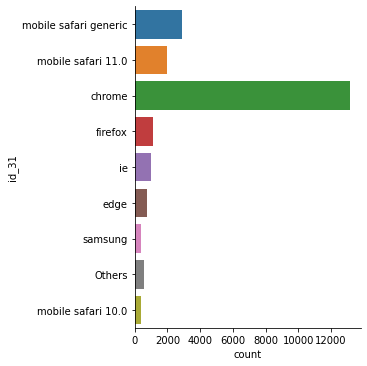

In [90]:
prop = train_imputed_b['id_31'].value_counts()/len(train_imputed_b)
train_imputed_b['id_31'] = np.where(train_imputed_b['id_31'].isin(prop[prop<0.01].reset_index()['index']), 'Others', train_imputed_b['id_31'])
sns.catplot(y='id_31',kind='count',data=train_imputed_b)

In [91]:
#On voit le nombre de modalités par variable
train_imputed_b.select_dtypes('object').nunique()

ProductCD        4
card4            4
card6            3
P_emaildomain    7
R_emaildomain    8
id_12            2
id_15            3
id_16            2
id_28            2
id_29            2
id_31            9
id_35            2
id_36            2
id_37            2
id_38            2
DeviceType       2
dtype: int64

On se retrouve finalement avec un nombre de modalités acceptables pour les variables qualitatives.

Ensuite, afin que les algorithmes puissent traiter convenablement les variables qualitatives, on créé des variables binaires pur chacune des modalités.

In [92]:
#On met les variables categorielles dans un type exploitable
train_use = train_imputed_b.copy()
quali_col = train_imputed_b.select_dtypes('object').columns
for var in quali_col :
  train_imputed_b[var] = train_imputed_b[var].astype('category')

train_quant = train_imputed_b.drop(quali_col,axis=1)
train_imputed_b = pd.merge(train_quant,pd.get_dummies(train_imputed_b[quali_col]),right_index=True,left_index=True)

## Modelisation

In [95]:
warnings.filterwarnings('ignore')

On commence par convertir les bases de travail au format **dask** pour permettre des traitements distribués


On compare les temps d'execution dans le modèle logistique pour valider l'utilisation du format dask

In [112]:
Y_train=train_imputed_b['isFraud'].astype('int')
X_train=train_imputed_b.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)

In [113]:
## Execution sur pandas
model = LogisticRegression()
%time model.fit(X_train_st, Y_train)

CPU times: user 2.79 s, sys: 565 ms, total: 3.35 s
Wall time: 1.88 s


LogisticRegression()

In [114]:
## Execution avec dask
with joblib.parallel_backend('dask'):
  model = LogisticRegression()
  %time model.fit(X_train_st, Y_train)

CPU times: user 230 ms, sys: 76.5 ms, total: 307 ms
Wall time: 1.99 s


Comme on peut le voir les temps de traitements au niveau du CPU sont bien plus faible avec le traitement distribué. On adopte alors cette approche dans la suite.

### **Logistic Regression (Features Selection and execution)**

**First execution of Logistic Regression**

In [115]:
cv_estimator=LogisticRegression(C=1,random_state=42)

In [116]:
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st, Y_train)

In [118]:
with joblib.parallel_backend('dask'):
  cv_scores = cross_val_score(cv_estimator, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.855869141512596

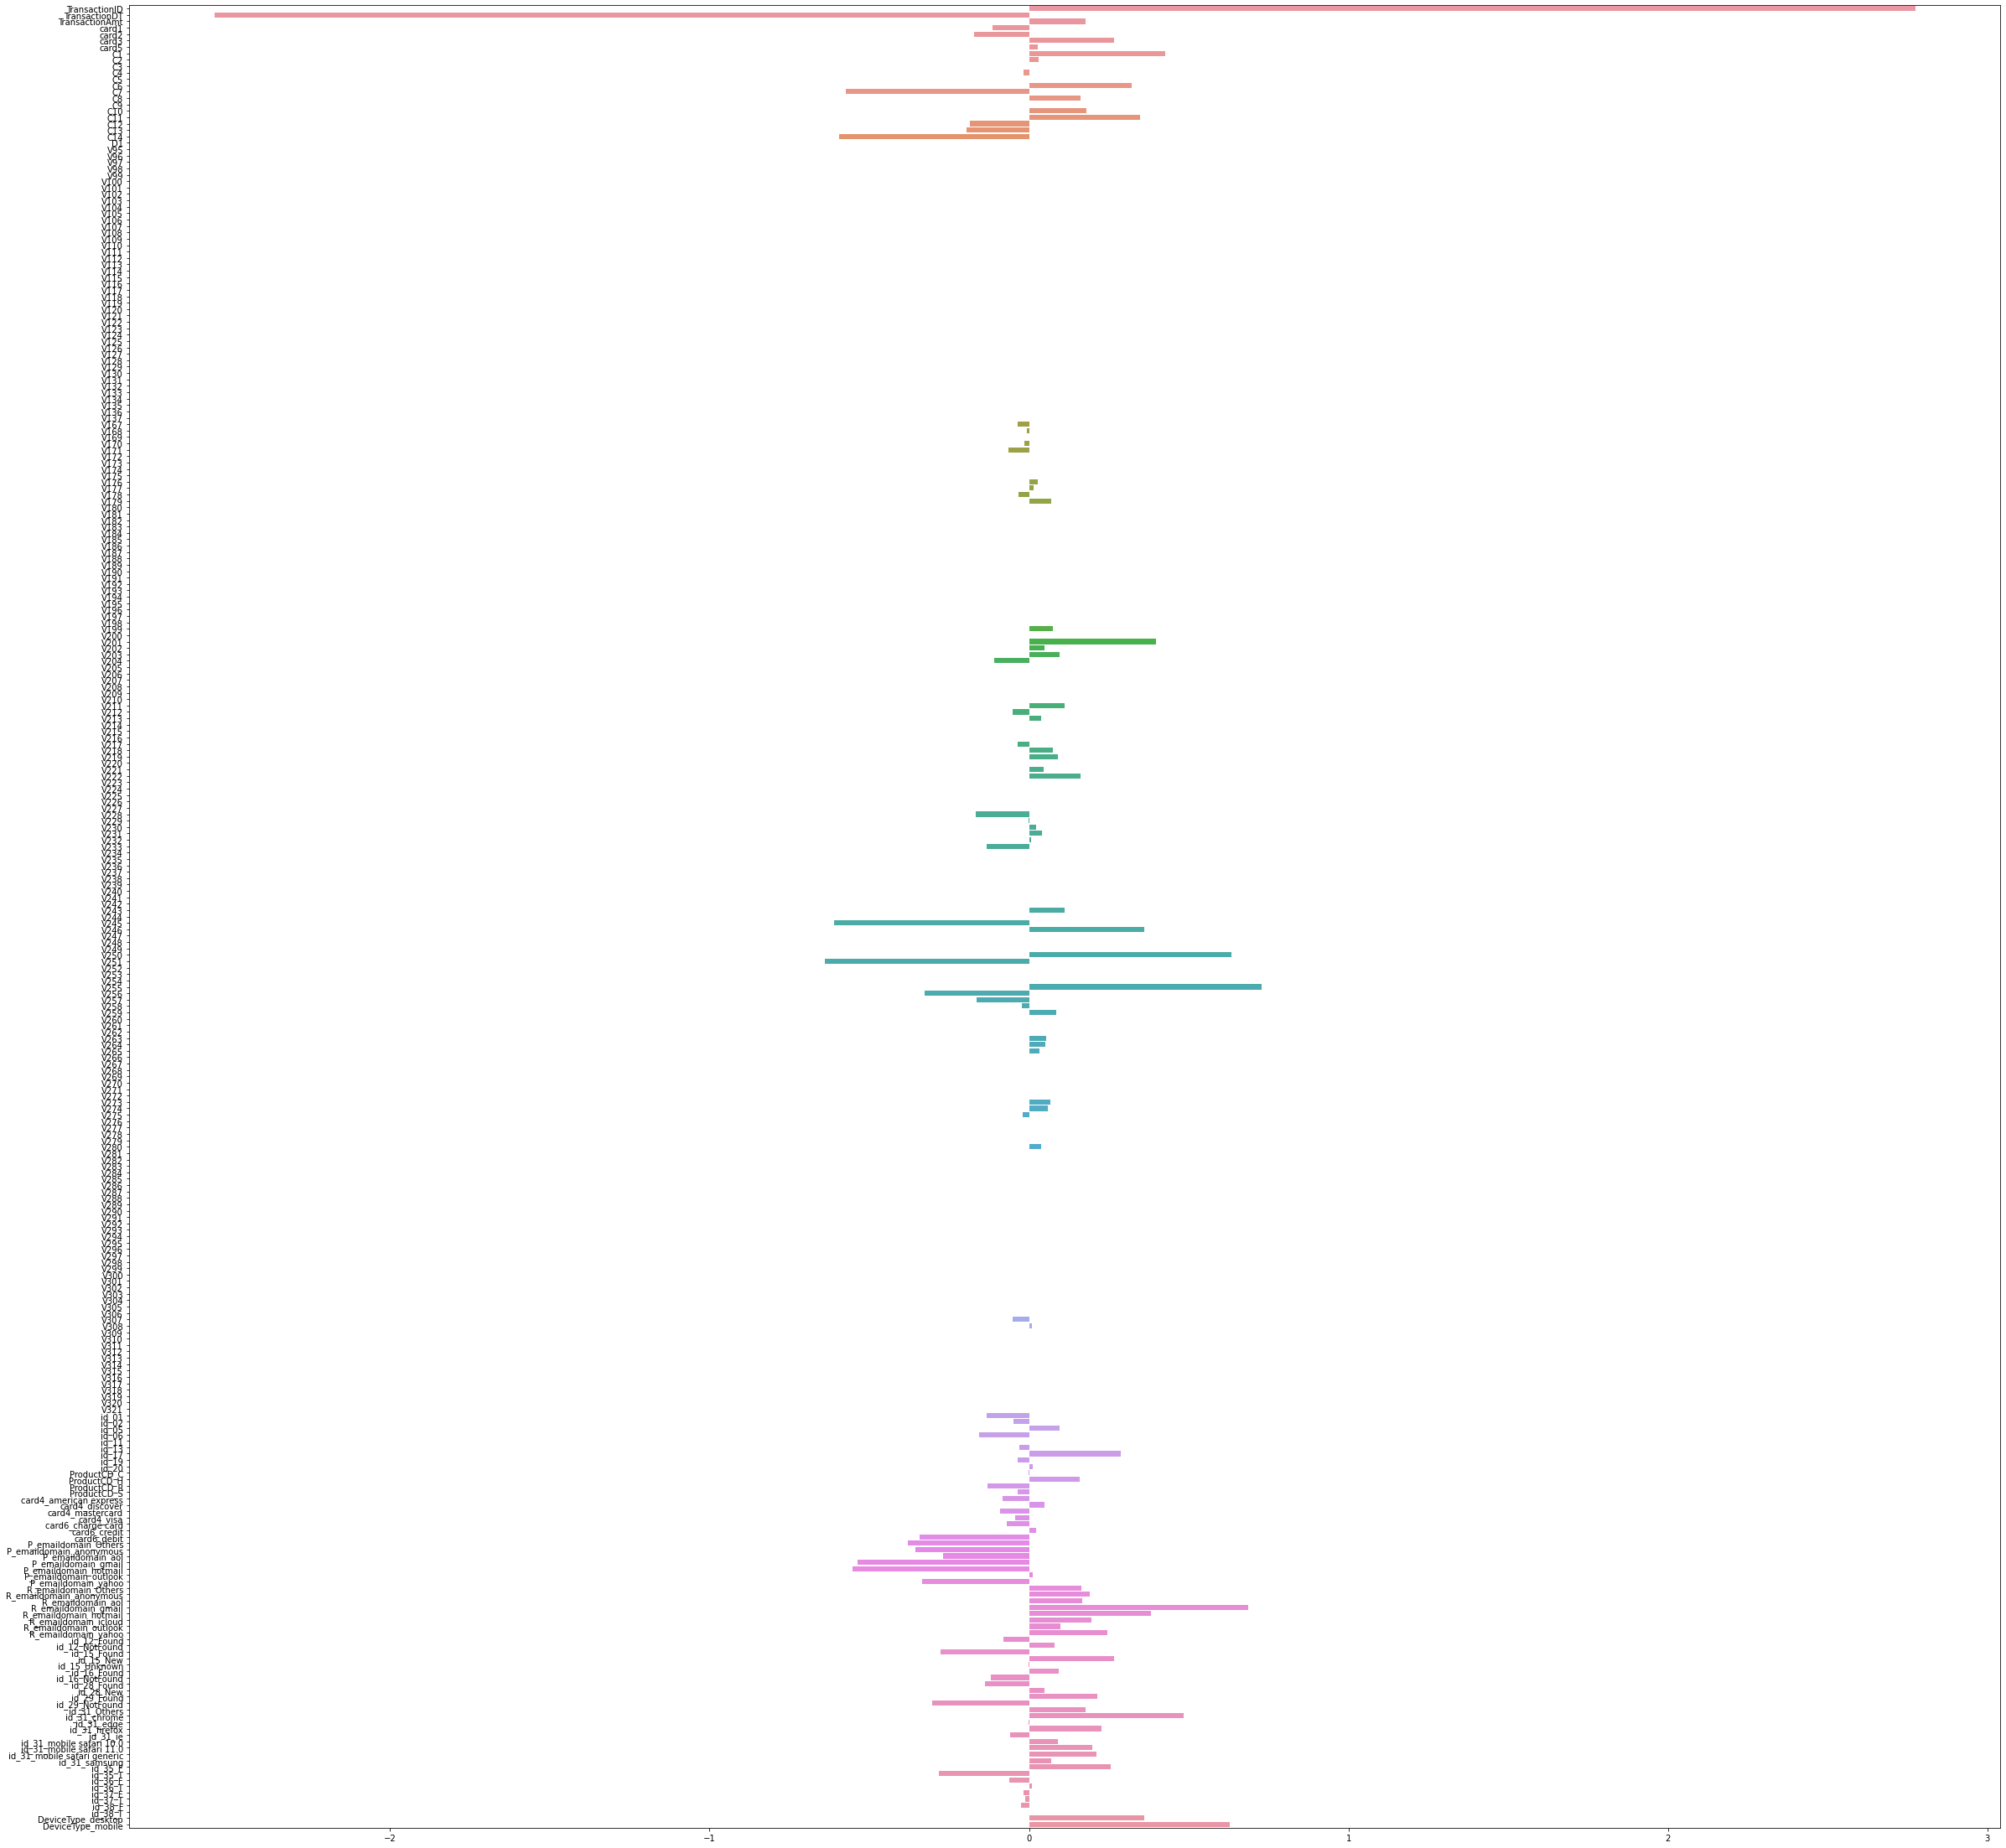

In [119]:
importance = cv_estimator.coef_[0]
imp=np.zeros(len(importance))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

In [120]:
#Courbe pour l'évolution du cv_score en fonction du paramètre C
import time

vscores=np.zeros(100)
vtime=np.zeros(100)
for i in range(100):
  tps1 = time.clock()
  with joblib.parallel_backend('dask'):
    logit=LogisticRegression(C=i+1,random_state=42)
    cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
  tps2 = time.clock()
  vscores[i]=cv_scores.mean()
  vtime[i]=tps2-tps1

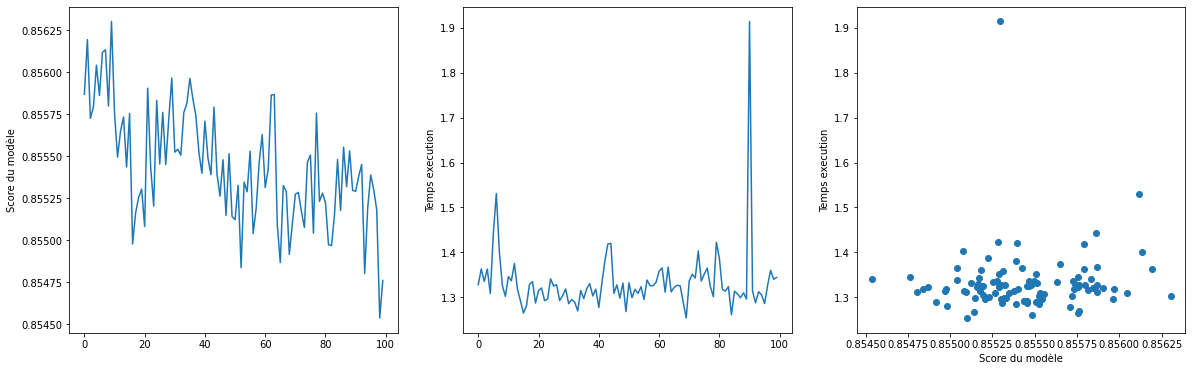

In [121]:
plt.figure(figsize=(20,6))

plt.subplot(131)
plt.plot(vscores)
plt.ylabel('Score du modèle')

plt.subplot(132)
plt.plot(vtime)
plt.ylabel('Temps execution')

plt.subplot(133)
plt.scatter(vscores,vtime)
plt.ylabel('Temps execution')
plt.xlabel('Score du modèle')
plt.show()


**Recursive Feature Elimination with Cross Validation**

In [ ]:
cv_estimator=LogisticRegression(C=2,random_state=42)
with joblib.parallel_backend('dask'):
  cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="f1")
  cv_selector = cv_selector.fit(X_train_st, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans

In [ ]:
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
   rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)

In [ ]:
pp=[]
for i in range(len(cv_selector.support_)):
  if cv_selector.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(cv_estimator, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(cv_selector.grid_scores_) + 1), cv_selector.grid_scores_, color='#303F9F', linewidth=3)
plt.axes.xaxis.set_ticks(range(1, len(cv_selector.grid_scores_) + 1))
plt.axes.xaxis.set_ticklabels(range(1, len(cv_selector.grid_scores_) + 1), rotation = 90, color = 'red', fontsize = 8, style = 'italic', verticalalignment = 'center')
plt.axes.xaxis.grid(True, which = 'both', color = 'gray', zorder = 0)
plt.show()

**Model with best features from RFECV**

In [ ]:
X_train1= X_train.filter(rfecv_features,axis=1)
X_train_st1=scaler.fit_transform(X_train1)
with joblib.parallel_backend('dask'):
  cv_estimator.fit(X_train_st1, Y_train)
  cv_scores = cross_val_score(cv_estimator, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

In [ ]:
## Confusion matrix 
from sklearn import metrics
with joblib.parallel_backend('dask'):
  Y_pred=cv_estimator.predict(X_train1)
  cnf_matrix = metrics.confusion_matrix(Y_train,Y_pred)
cnf_matrix

In [ ]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(Y_train,Y_pred))
print("Precision:",metrics.precision_score(Y_train,Y_pred))
print("Recall:",metrics.recall_score(Y_train,Y_pred))

In [ ]:
# ROC Curve
with joblib.parallel_backend('dask'):
  Y_pred_proba = cv_estimator.predict_proba(X_train1)[::,1]
  fpr, tpr, _ = metrics.roc_curve(Y_train,  Y_pred_proba)
  auc = metrics.roc_auc_score(Y_train, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

### **Random Forest (Features Selection and execution)**

**SVM**

svm tuning

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, Y_train) 
print(grid.best_params_) 


In [ ]:
start_time = datetime.now()
Supoort_vector=SVC(C=0.1,gamma=0.01,kernel='rbf')
cv_scores = cross_val_score(Support_vector, X_train, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time = datetime.now()
time_SVM=end_time-start_time

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
start_time=datetime.now()
decision_tree_gini=DecisionTreeClassifier(criterion='gini',random_state=42)
cv_scores = cross_val_score(decision_tree_gini, X_train1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_decision_tree=end_time-start_time

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cv_estimator = RandomForestClassifier(random_state =42)
cv_estimator.fit(X_train, Y_train)
cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring="accuracy")
cv_selector = cv_selector.fit(X_train, Y_train)
rfecv_mask = cv_selector.get_support() #list of booleans
rfecv_features = [] 
for bool, feature in zip(rfecv_mask, X_train.columns):
 if bool:
 rfecv_features.append(feature)
print("Optimal number of features :", cv_selector.n_features_)
print("Best features :", rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
X_train_rf=X_train.filter(rfecv_features,axis=1)
start_time=datetime.now()
randomforest=RandomForestClassifier(random_state=42,n_jobs=-1,criterion="gini")
cv_scores = cross_val_score(randomforest, X_train_rf, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()
end_time=datetime.now()
time_random_forest=end_time-start_time

**Boosting**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train,Y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_